# National Performance (Part 1)

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read all predictions

In [7]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data
from scripts.drafts.delta_error import DeltaError
SAVE = True
RELOAD = False

if RELOAD:
    pet_ealstm_ensemble_dir = data_dir / "runs/ensemble_pet_ealstm"
    ealstm_preds = read_ensemble_results(pet_ealstm_ensemble_dir)

    lstm_ensemble_dir = data_dir / "runs/ensemble_pet"
    lstm_preds = read_ensemble_results(lstm_ensemble_dir)

    raw_fuse_path = data_dir / "RUNOFF/FUSE"
    fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])

    # get matching stations
    all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
    all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)
    lstm_preds = lstm_preds.sel(
        station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
    )
    ealstm_preds = ealstm_preds.sel(
        station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
    )

    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
    all_preds = processor.all_preds
    
    if SAVE:
        all_preds.to_netcdf(data_dir / "RUNOFF/all_preds.nc")

else:
    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
    
# all_preds

In [8]:
import pickle
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

RELOAD = False

if RELOAD:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True)
    all_metrics = get_metric_dataframes_from_output_dict(all_errors)
    if SAVE:
        pickle.dump(all_errors, (data_dir / "RUNOFF/all_errors.pkl").open("wb"))
        pickle.dump(all_metrics, (data_dir / "RUNOFF/all_metrics.pkl").open("wb"))
    
else:
    all_errors = pickle.load((data_dir / "RUNOFF/all_errors.pkl").open("rb"))
    all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
    
metrics_xr = xr.Dataset(all_metrics).rename({"dim_1": "model"})
# kratzert_models = pickle.load((data_dir / "RUNOFF/kratzert_models.pkl").open("rb"))
# kratzert_metrics = pickle.load((data_dir / "RUNOFF/kratzert_metrics.pkl").open("rb"))

# Seasonal

In [9]:
import pickle 

seasonal_errors = pickle.load((data_dir / "RUNOFF/seasonal_errors.pkl").open("rb"))
seasonal_metrics = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_metrics[season] = get_metric_dataframes_from_output_dict(seasonal_errors[season])
    

from scripts.drafts.calculate_error_scores import convert_season_to_xr
season_xr = convert_season_to_xr(seasonal_metrics)

# Calculate ∆Metrics

In [10]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs

lstm_delta, ealstm_delta = calculate_all_delta_dfs(
    all_metrics,
    absolute_metrics=[
            "fms",
            "flv",
            "fhv",
            "bias_error",
            "bias_error_pct",
            "std_error",
            "std_error_pct",
        ],
)

In [11]:
from scripts.drafts.plots import kwargs_dict_config
from typing import Union, Tuple, Dict, Any


color_lookup = {
    m: sns.color_palette()[2:][ix] for (ix, m) in enumerate(["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"])
}

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", clip: Union[str, Tuple[float]] = "auto", ax=None):
        if clip  == "auto":
            clip = (
                delta_df.quantile(q=0.05).min(), delta_df.quantile(q=0.95).max()
            )
        kde_kws = {"clip": clip}
        hist_kws = {"range": clip, "density": True}
        if ax is None:
            f, ax = plt.subplots()
        [
            sns.distplot(delta_df[c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c, color=color_lookup[c])
            for c in ["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]
        ]

        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel(f"$\Delta${metric}")
        ax.legend()
        sns.despine()


In [12]:
# # data = lstm_delta["fhv"].drop(["persistence", "climatology_doy", "climatology_mon", "EALSTM"], axis=1)
# metric = "nse"
# kde_plot_deltas(lstm_delta[metric], clip="auto", metric=f"|%Bias{metric.upper()}|")

### Plot the RAW ∆NSEs for the comparison models

In [13]:
metric = "nse"
worse_basins = {}
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
for ix, model in enumerate(models):
    delta_df = lstm_delta[metric]
    worse_basins[model] = delta_df.loc[delta_df[model] < 0].index
    

flatten = lambda t: [item for sublist in t for item in sublist]
all_worse_sids = set(flatten(worse_basins.values()))

In [14]:
models = ["TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]

order_ = all_metrics["nse"].loc[[int(sid) for sid in all_worse_sids], models + ["EALSTM", "LSTM"]] # .drop("Name", axis=1)
order_ = (order_["LSTM"] - order_.drop("LSTM", axis=1).T).min().sort_values()

print(f"Median Absolute Delta NSE for the Stations where DeltaNSE < 0: {order_.abs().median():.02f}")
print(order_.index)

Median Absolute Delta NSE for the Stations where DeltaNSE < 0: 0.02
Int64Index([54052, 41019, 41004, 34008, 28050, 26008, 34004, 40018, 40004,
            33054, 84016, 32006, 28015, 42016, 41003, 54015, 43021, 39105,
            21023, 27025, 25020, 27035, 54063, 92001, 28012, 28066,  5003,
            41001, 42010, 80004],
           dtype='int64', name='station_id')


In [15]:
worse_nse = all_metrics["nse"].loc[[int(sid) for sid in all_worse_sids]]
worse_df = worse_nse[models + ["EALSTM", "LSTM"]]
worse_df = worse_df.stack().reset_index(-1).rename({"level_1": "model", 0: "nse"}, axis=1)

names = static[["gauge_name"]].to_dataframe()
names = names.loc[np.isin(names.index, worse_df.index)]
worse_df = names.join(worse_df).rename({"gauge_name": "Name"}, axis=1).loc[[int(sid) for sid in order_.index]]

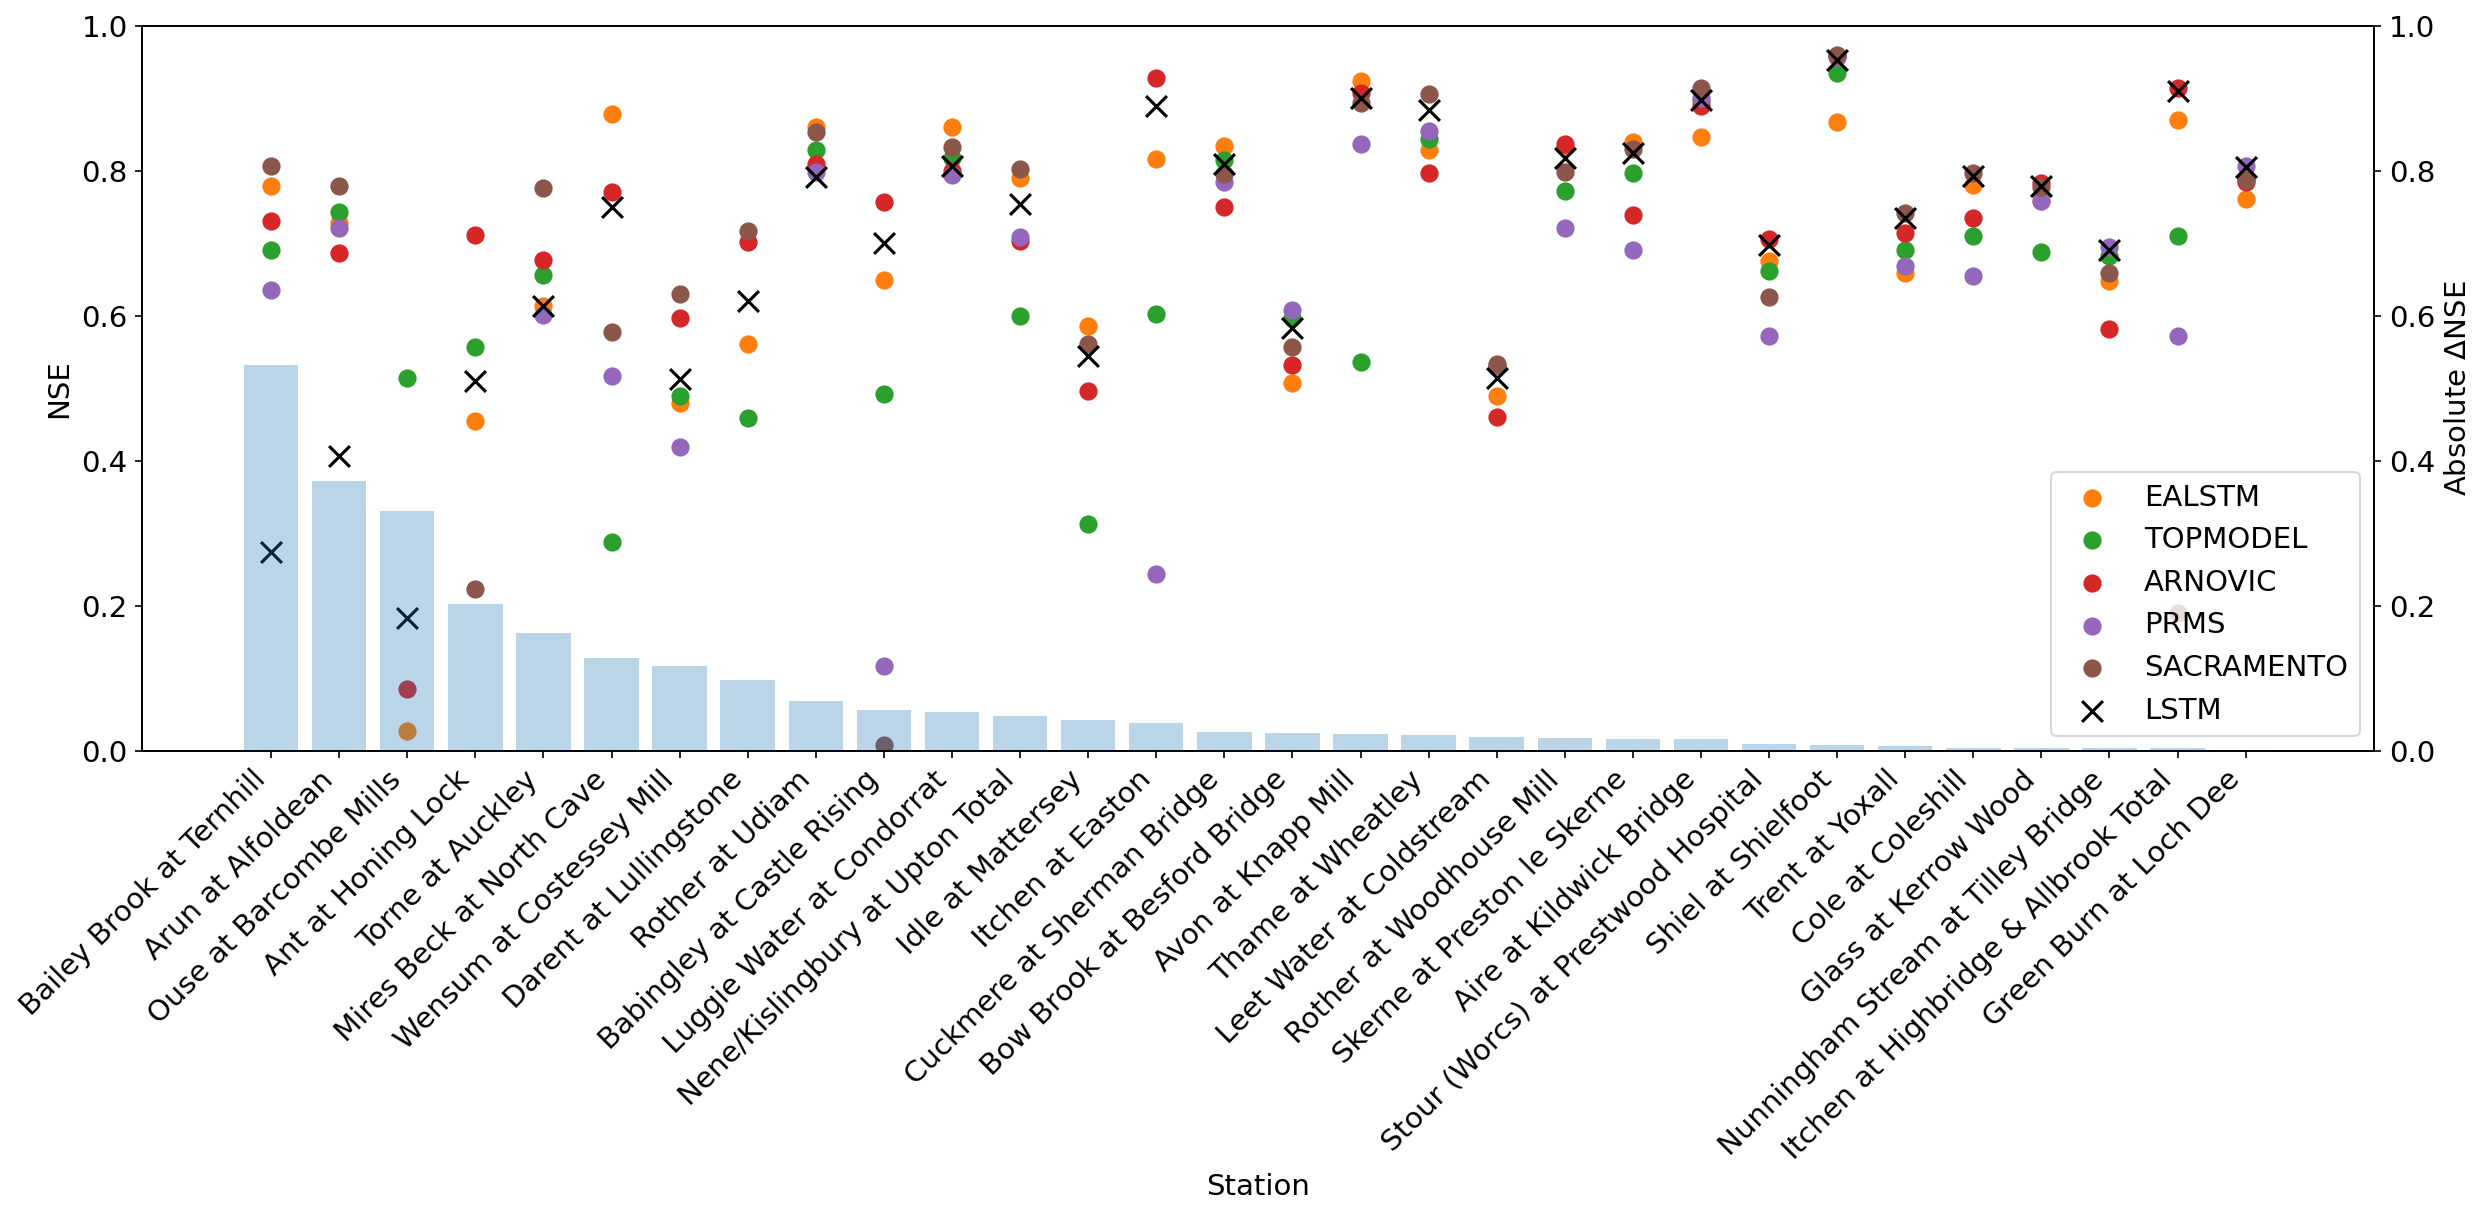

In [16]:
scale = 1.6

# plot_data = worse_df 
# plot_data["nse"] = plot_data["nse"] + np.random.normal(0, 0.01, len(plot_data["nse"]))
# TOPMODEL (green), VIC (red), PRMS (purple), Sacramento
model_order = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
abs_ = True
f, ax = plt.subplots(figsize=(12*scale, 4*scale))

# PLOT THE CONCEPTUAL MODEL NSE PERFORMANCE
colors = sns.color_palette()[1: len(model_order)]
for ix, model in enumerate(model_order[1:]):
    plot_data = worse_df.loc[worse_df["model"] == model]
    ax.scatter(plot_data["Name"], plot_data["nse"], color=colors[ix], s=60, label=model)

# PLOT THE LSTM MODEL NSE PERFORMANCE
plot_data = worse_df.loc[worse_df["model"] == "LSTM"]
ax.scatter(plot_data["Name"], plot_data["nse"], color="k", marker="x", s=100, label="LSTM")
plt.xticks(rotation=45, ha="right")

ax.set_xlabel("Station")
ax.set_ylabel("NSE")
ax.set_ylim(0, 1)
ax.legend()

# Plot the raw difference
ax2 = ax.twinx()
if abs_:
    ax2.bar(plot_data.drop_duplicates()["Name"], abs(order_), alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Absolute $\Delta$NSE")
else:
    ax2.bar(plot_data.drop_duplicates()["Name"], order_, alpha=0.3)
    ax2.set_ylim(-0.7, 0)
    ax2.set_ylabel("$\Delta$NSE")
# sns.despine()

# All Errors Table

In [17]:
metrics = ["nse", "kge", "log_nse", "bias_error_pct", "std_error_pct", "correlation"]
metrics = ["nse", "bias_error_pct", "std_error_pct", "correlation", "fms", "flv", "fhv"]
metrics = ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"]

models = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM']

summaries = ["mean", "median"]
# summaries = ["median", "q5"]

all_summary = []
for metric in metrics:
    summary_df = all_metrics[metric][models].describe(percentiles=[0.05, 0.5, 0.95]).rename(
        {
            "5%": "q5",
            "50%": "median",
            "95%": "q95",
        }
    ).loc[summaries].T
    
    if len(summaries) > 1:
        summary_df.columns = pd.MultiIndex.from_arrays(
            ([metric for _ in range(len(summaries))], summaries)
        )
    else:
        summary_df.columns = [metric]

    all_summary.append(summary_df)

all_metric_summary = pd.concat(all_summary, axis=1)
all_metric_summary

nse           bias_error           std_error            \
                mean    median       mean    median      mean    median   
TOPMODEL    0.707951  0.761844  -0.024765 -0.038957 -0.109190 -0.095095   
ARNOVIC     0.691012  0.780652   0.097358  0.063110 -0.085957 -0.100167   
PRMS        0.437296  0.766325   0.121666  0.034821  0.021407 -0.030900   
SACRAMENTO  0.666026  0.799887   0.022203 -0.011675 -0.043654 -0.069853   
EALSTM      0.842735  0.860409  -0.020294 -0.030848 -0.121365 -0.120456   
LSTM        0.865883  0.884243  -0.008418 -0.019847 -0.083392 -0.085603   

           correlation                  fms                    flv  \
                  mean    median       mean     median        mean   
TOPMODEL      0.855677  0.882474  14.183265   5.704007  -28.931012   
ARNOVIC       0.884546  0.896385   5.338883   2.253460 -154.670525   
PRMS          0.872862  0.890359  41.266001  35.243480 -385.692236   
SACRAMENTO    0.885127  0.903701  34.055674  27.909987 -267.283940   
EALSTM        0.930271  0.936856  -6.307213  -7.085841    3.153079   
LSTM          0.939232  0.945526  -4.278531  -3.970927   15.381000   

                              fhv             
                median       mean     median  
TOPMODEL     42.218320 -12.429073 -13.038439  
ARNOVIC     -60.335741 -13.486530 -14.657044  
PRMS       -315.245711 -11.485742 -15.107023  
SACRAMENTO -195.916586 -14.094464 -16.194491  
EALSTM       28.125100 -12.091735 -12.849145  
LSTM         26.286887  -8.428548  -8.979120

In [18]:
print(all_metric_summary.to_latex(float_format="%.2f", multirow=True))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{nse} & \multicolumn{2}{l}{bias\_error} & \multicolumn{2}{l}{std\_error} & \multicolumn{2}{l}{correlation} & \multicolumn{2}{l}{fms} & \multicolumn{2}{l}{flv} & \multicolumn{2}{l}{fhv} \\
{} & mean & median &       mean & median &      mean & median &        mean & median &  mean & median &    mean &  median &   mean & median \\
\midrule
TOPMODEL   & 0.71 &   0.76 &      -0.02 &  -0.04 &     -0.11 &  -0.10 &        0.86 &   0.88 & 14.18 &   5.70 &  -28.93 &   42.22 & -12.43 & -13.04 \\
ARNOVIC    & 0.69 &   0.78 &       0.10 &   0.06 &     -0.09 &  -0.10 &        0.88 &   0.90 &  5.34 &   2.25 & -154.67 &  -60.34 & -13.49 & -14.66 \\
PRMS       & 0.44 &   0.77 &       0.12 &   0.03 &      0.02 &  -0.03 &        0.87 &   0.89 & 41.27 &  35.24 & -385.69 & -315.25 & -11.49 & -15.11 \\
SACRAMENTO & 0.67 &   0.80 &       0.02 &  -0.01 &     -0.04 &  -0.07 &        0.89 &   0.90 & 34.06 &  27.91 & -267.28 & -195.92 & -14.09 & -

# Check the significance of the differences

In [19]:
from scripts.drafts.statistical_significance import run_test

In [20]:
all_tests = defaultdict(dict)

for metric in ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"]:
    models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC", "LSTM", "EALSTM"]
    for ref_model in models:
        all_tests[metric][ref_model] = run_test(all_metrics, test="wilcoxon", metric=metric, ref_model=ref_model)

In [21]:
ref_model = "LSTM"

for metric in all_tests.keys():
#     ref_model = all_metrics[metric].loc[:, models].median().idxmax()
    print(f"{metric} {ref_model} Significant for all:", all_tests[metric][ref_model].loc["p0.01"].sum() >= 5)
    if all_tests[metric][ref_model].loc["p0.01"].sum() == 4:
        for model in  all_tests[metric][ref_model].columns:
            print(f"\tIs {ref_model} significantly different from {model}", all_tests[metric][ref_model].loc["p0.01", model] == 1)

nse LSTM Significant for all: True
bias_error LSTM Significant for all: False
	Is LSTM significantly different from TOPMODEL True
	Is LSTM significantly different from PRMS True
	Is LSTM significantly different from SACRAMENTO False
	Is LSTM significantly different from ARNOVIC True
	Is LSTM significantly different from EALSTM True
std_error LSTM Significant for all: False
	Is LSTM significantly different from TOPMODEL True
	Is LSTM significantly different from PRMS True
	Is LSTM significantly different from SACRAMENTO True
	Is LSTM significantly different from ARNOVIC False
	Is LSTM significantly different from EALSTM True
correlation LSTM Significant for all: True
fms LSTM Significant for all: True
flv LSTM Significant for all: False
	Is LSTM significantly different from TOPMODEL True
	Is LSTM significantly different from PRMS True
	Is LSTM significantly different from SACRAMENTO True
	Is LSTM significantly different from ARNOVIC True
	Is LSTM significantly different from EALSTM Fals

# CDF Plots

In [22]:
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

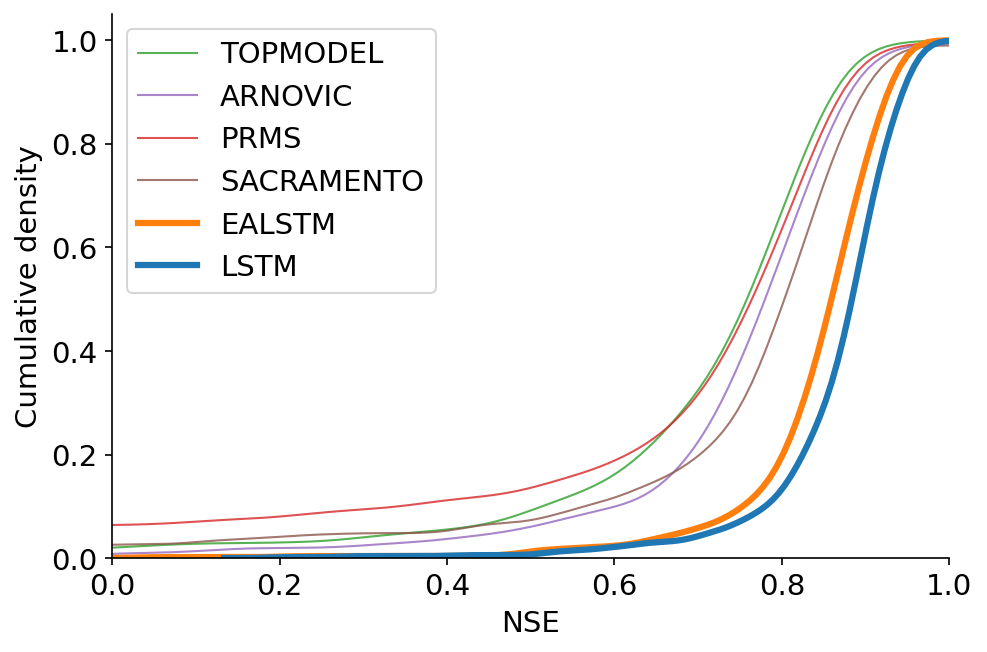

In [23]:
from scripts.drafts.plots import plot_cdf

f, ax = plt.subplots(figsize=FIGSIZE)
metrics = all_metrics["nse"].drop([c for c in  all_metrics["nse"].columns if "climatology" in c or "persistence" in c], axis=1)
plot_cdf(metrics, metric="NSE", title="", ax=ax, clip=(0, 1), median=True, summary_line=False);

In [24]:
clipping_lookup = {
    "nse": (0, 1),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
}

# f, axs = plt.subplots(2, 2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]*2))
# for ix, metric in enumerate(["kge", "correlation", "bias_ratio", "variability_ratio"]):
#     ax = axs[np.unravel_index(ix, (2,2))]
#     metric_data = all_metrics[metric].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
#     plot_cdf(metric_data, metric=metric, title="", ax=ax, clip=clipping_lookup[metric], median=True);
#     ax.legend()

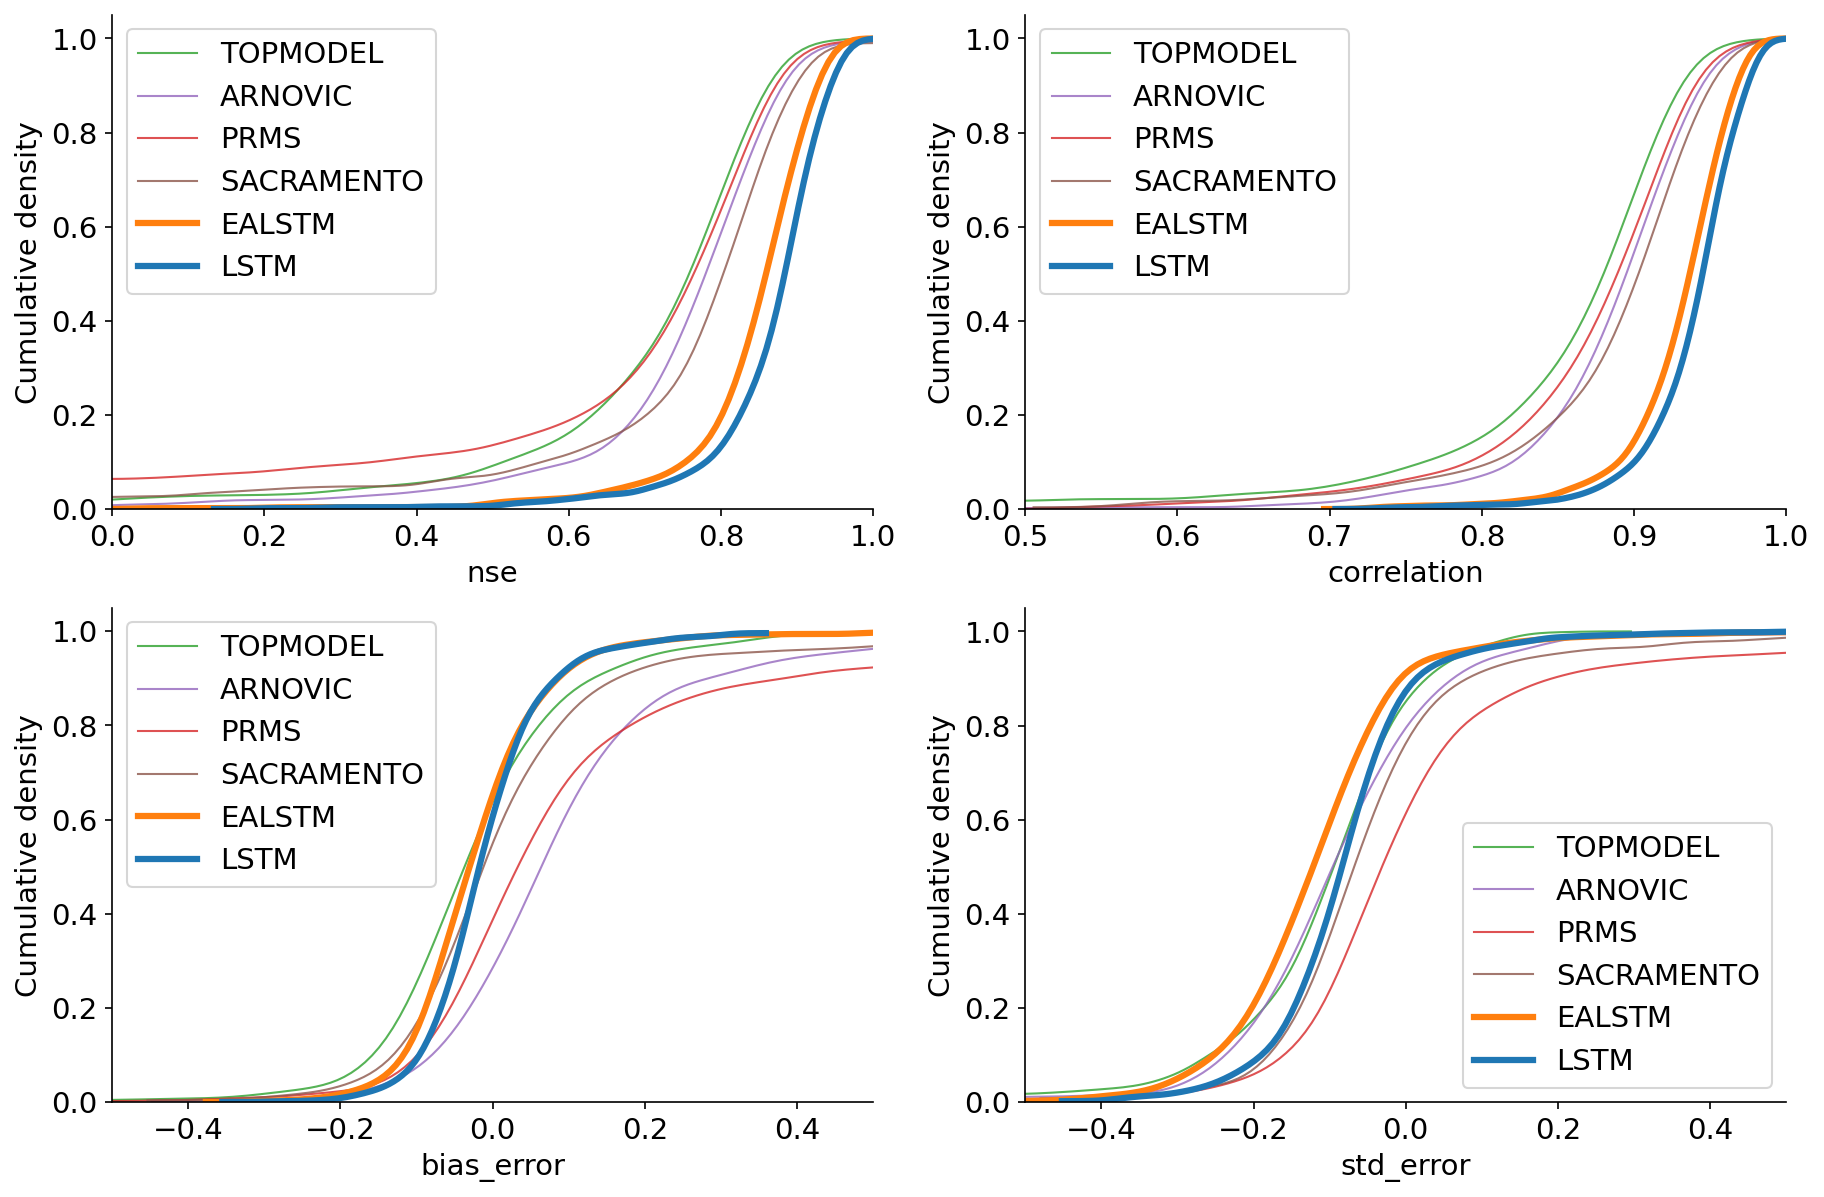

In [25]:
f, axs = plt.subplots(2, 2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]*2))

for ix, metric in enumerate(["nse", "correlation", "bias_error", "std_error"]):
    ax = axs[np.unravel_index(ix, (2,2))]
    metric_data = all_metrics[metric].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
    plot_cdf(metric_data, metric=metric, title="", ax=ax, clip=clipping_lookup[metric], median=True, summary_line=False, legend=True);
#     ax.legend().set_visible(False)

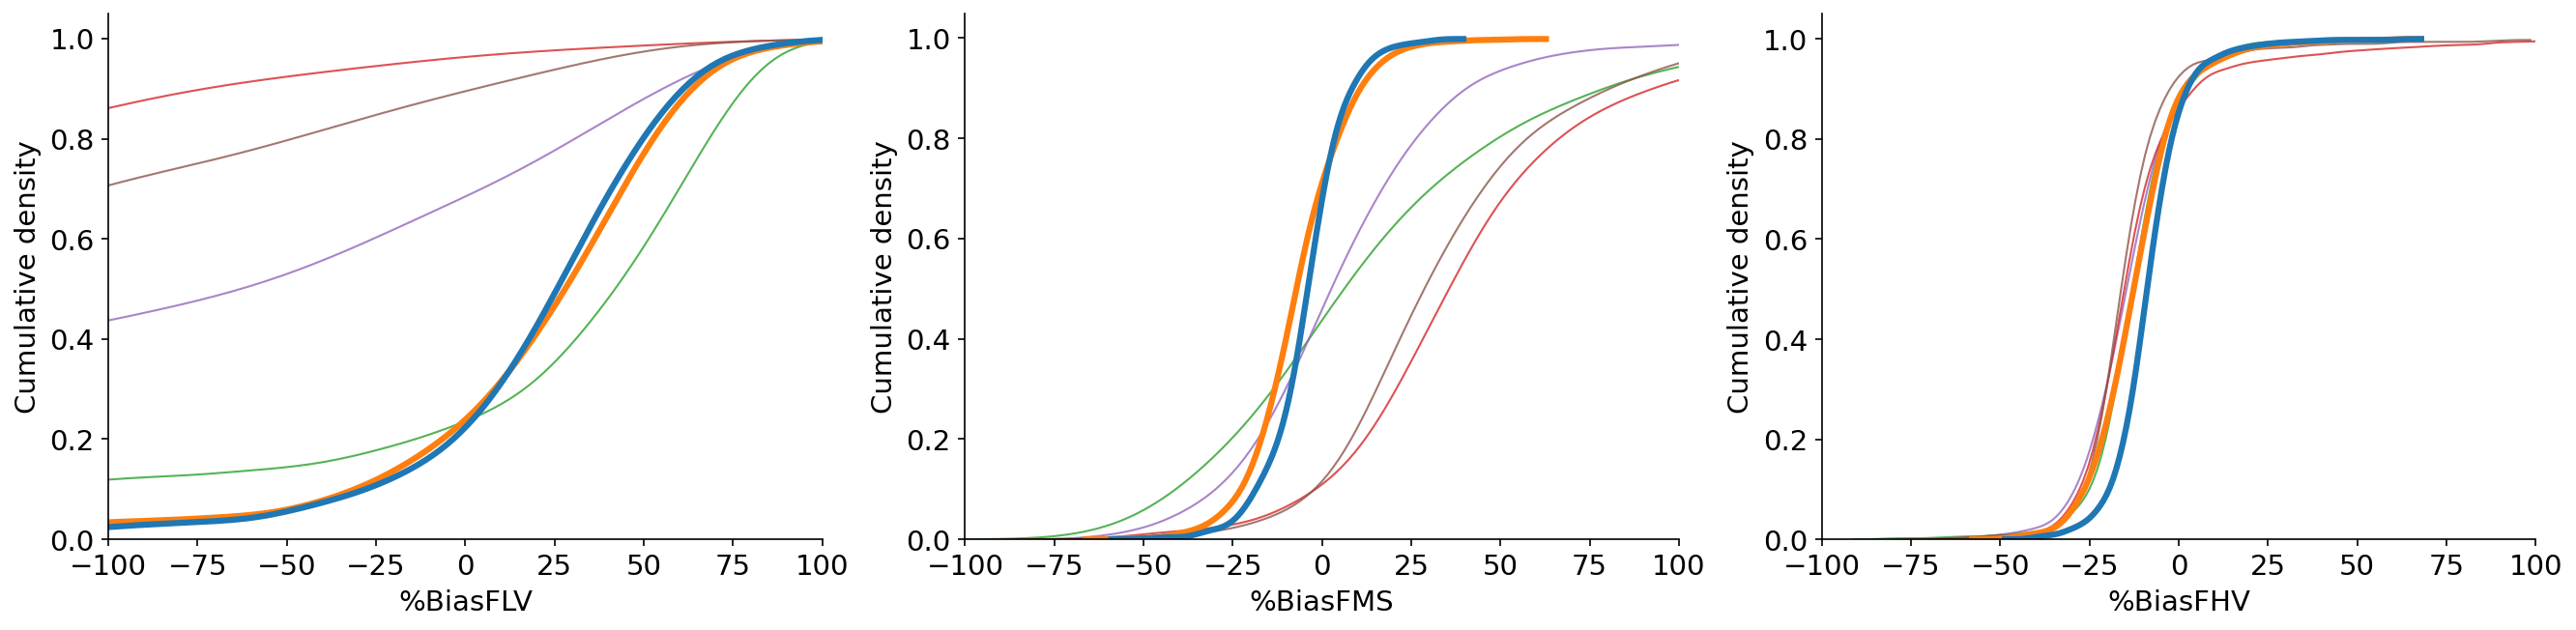

In [26]:
f, axs = plt.subplots(1, 3, figsize=(FIGSIZE[0]*3, FIGSIZE[1]))

for ix, metric in enumerate(["flv", "fms", "fhv"]):
    ax = axs[ix]
    metric_data = all_metrics[metric].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
    plot_cdf(metric_data, metric=metric, title="", ax=ax, clip=(-100, 100), median=True, summary_line=False, legend=False);
    ax.set_xlabel(f"%Bias{metric.upper()}")

# Spatial Plots

In [27]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [28]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [29]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Any, Optional, Dict


markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "log_nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # log nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'cividis_r', "markersize": markersize},    # kge   
    "inv_kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "mape": {"vmin": 0, "vmax": None, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},    # bias  
    "abs_pct_bias": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # abs_pct_bias
    "mam30_ape": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # mam30_ape  
    "correlation":{"vmin": 0.85, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},
    "bias_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},  
    "variability_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},
    "bias_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},  
    "std_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv":{"vmin": -100, "vmax": 100, 'cmap': 'RdBu', "markersize": markersize},
    "fms":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
    "fhv":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
}

from typing import List, Any 


def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _add_colorbar(ax: Any, kwargs: Dict[str, float], title: str = ""):
    assert all(np.isin(["cmap", "vmin", "vmax"], [k for k in kwargs.keys()]))
    # get the legend / colorbar
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=kwargs["cmap"], norm=plt.Normalize(vmin=kwargs["vmin"], vmax=kwargs["vmax"]))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    # cbar.set_label('title', rotation=270)



def _plot_geospatial(metric_data: gpd.GeoDataFrame, metric: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(metric, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

def plot_geospatial_data_per_model(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    assert all(np.isin(metrics, model_data.columns))
    
    n_metrics = len(metrics)
    if n_metrics == 3:
        fig, axs = plt.subplots(1, 3, figsize=(5*n_metrics, 8))
        shape = (1, 3)
    else:
        nrows = (n_metrics // 2) + (n_metrics % 2)
        fig, axs = plt.subplots(nrows, 2, figsize=(5*2, 8*nrows))
        shape = (nrows, 2)
        
    for ix, metric in enumerate(metrics):
        ax = axs[np.unravel_index(ix, shape)]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        ax = _plot_geospatial(model_data, metric=metric, ax=ax, cax=cax, kwargs=opts[metric])
        ax.set_title(metric.upper())
        
    fig.tight_layout()
#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);


def plot_geospatial_data_per_metric(metric_data, metric: str, models: List[str] = ["LSTM", "EALSTM", "SACRAMENTO"], legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    assert all(np.isin(models, metric_data.columns))
    n_models = len(models)
    
    scale = 0.6
    fig, axs = plt.subplots(1,  n_models, figsize=(5*n_models*scale, 8*scale))
    shape = (n_models,)

    for ix, model in enumerate(models):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        ax = _plot_geospatial(metric_data, metric=model, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(model.upper())
        if not legend:
            pass
    fig.tight_layout()

    
def plot_metric_data_per_season(metric_data, metric="nse", legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    assert "season" in metric_data.columns
    assert all(np.isin(seasons, metric_data["season"].unique()))
    n_seasons = len(seasons)
    
    # build the subplot
    scale = 0.6
    fig, axs = plt.subplots(1,  n_seasons, figsize=(5*n_seasons*scale, 8*scale))
    shape = (n_seasons,)

    for ix, season in enumerate(seasons):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        # subset the seasonal points
        plot_data = metric_data.loc[metric_data["season"] == season]
        ax = _plot_geospatial(plot_data, metric=metric, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(season.upper())
    
    fig.tight_layout()


    return

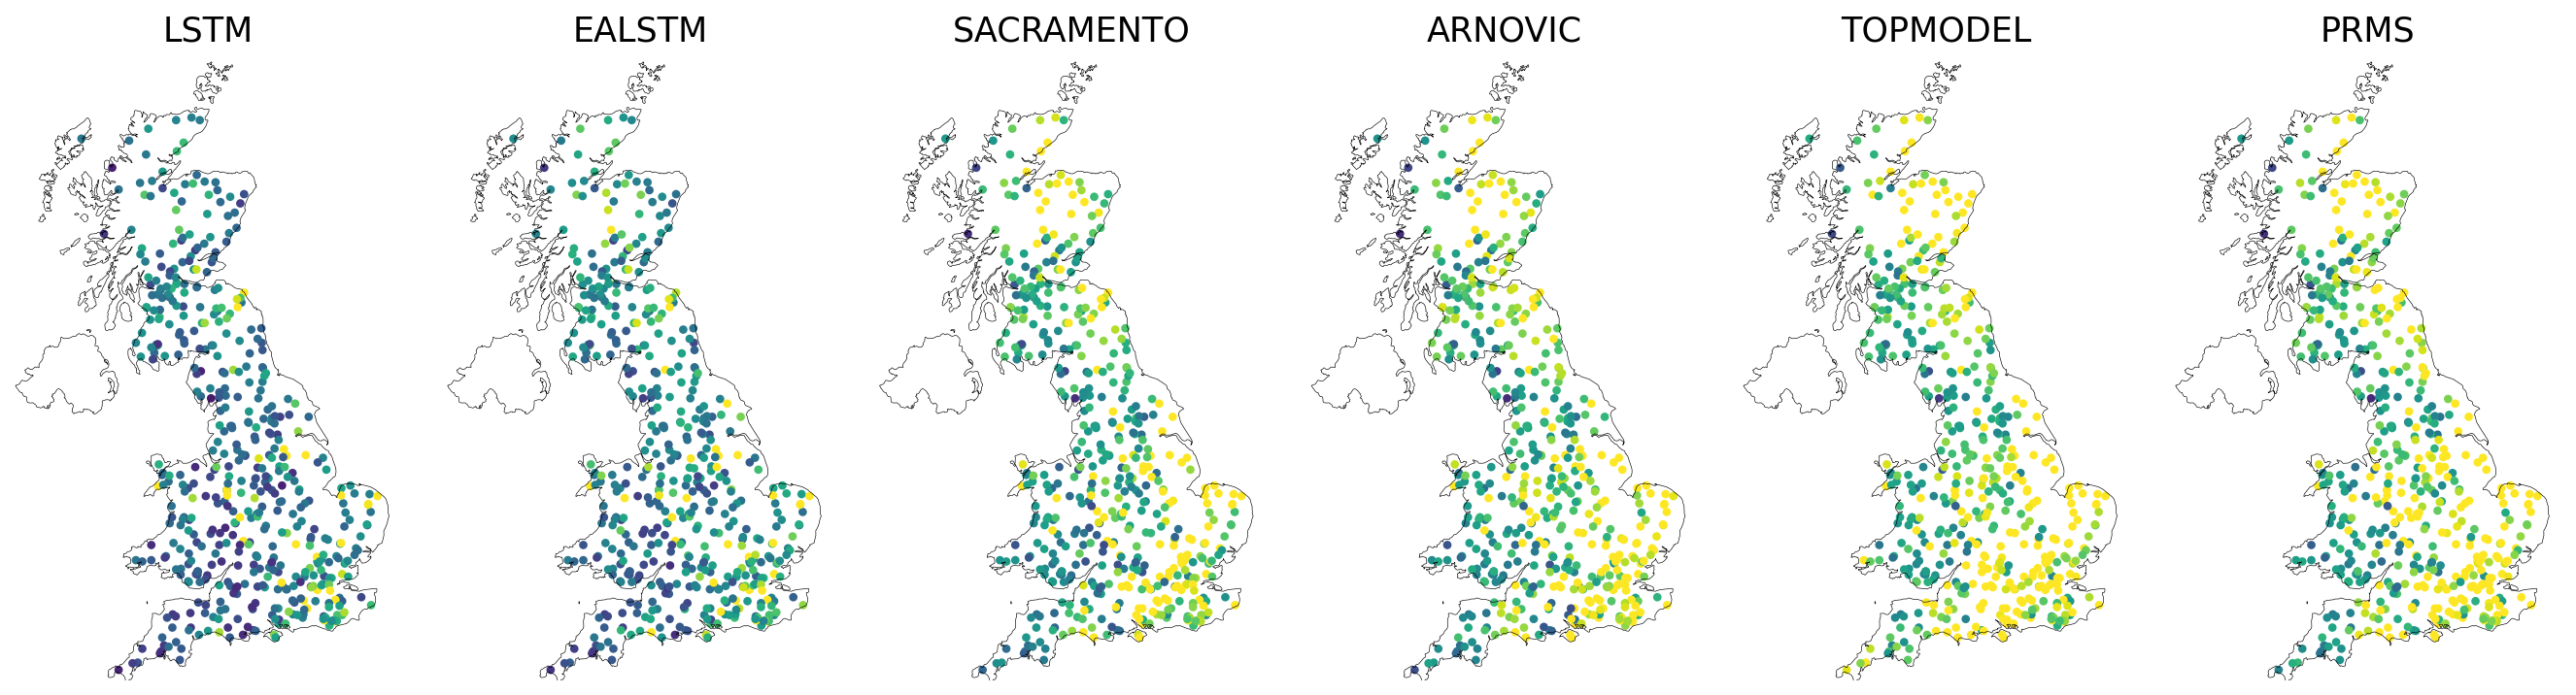

In [64]:
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["nse"]), metric="nse", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
# plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["correlation"]), metric="correlation", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
# plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["bias_error"]), metric="bias_error", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
# plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["std_error"]), metric="std_error", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])

In [32]:
if False:
    model = "LSTM"

    for metric in ["nse", "correlation", "bias_error", "std_error", "flv", "fms", "fhv"]: 
        f, ax = plt.subplots()
        kwargs = opts[metric]
        _plot_geospatial(metric_data=create_geospatial_data(all_metrics[metric]), metric=model, ax=ax, kwargs=kwargs, legend=False)
        _add_colorbar(ax, kwargs, title=metric)
        ax.set_title(metric)
        break

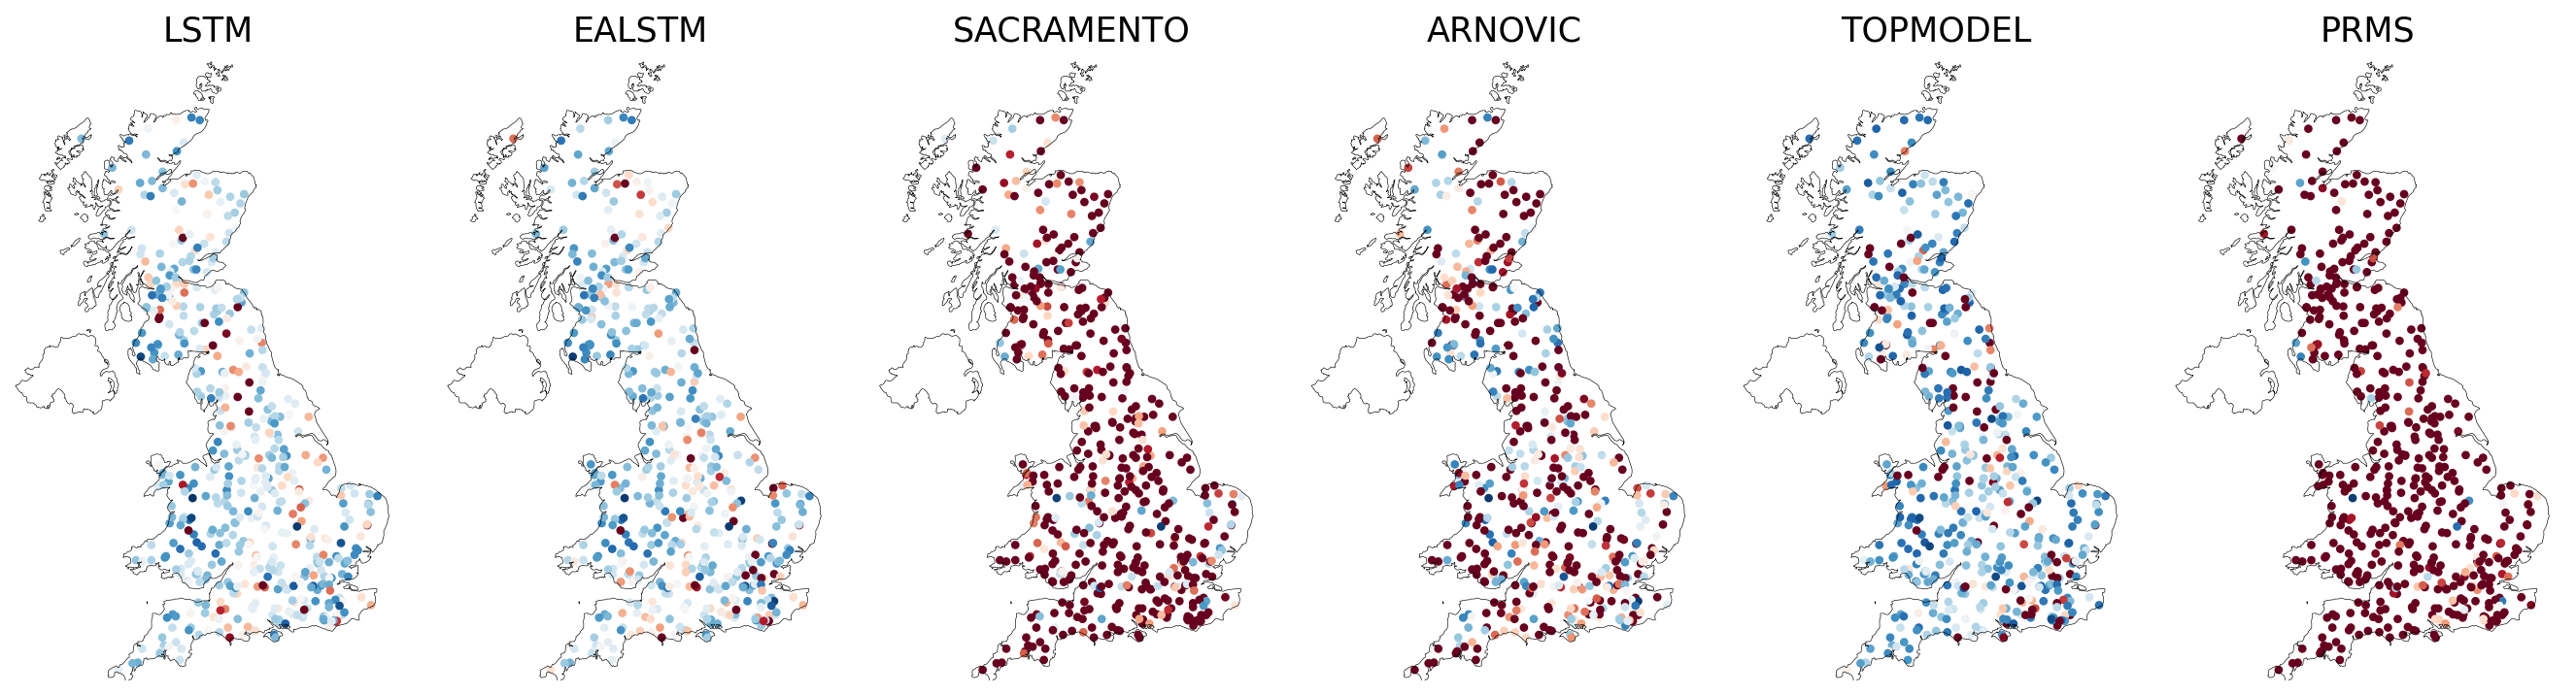

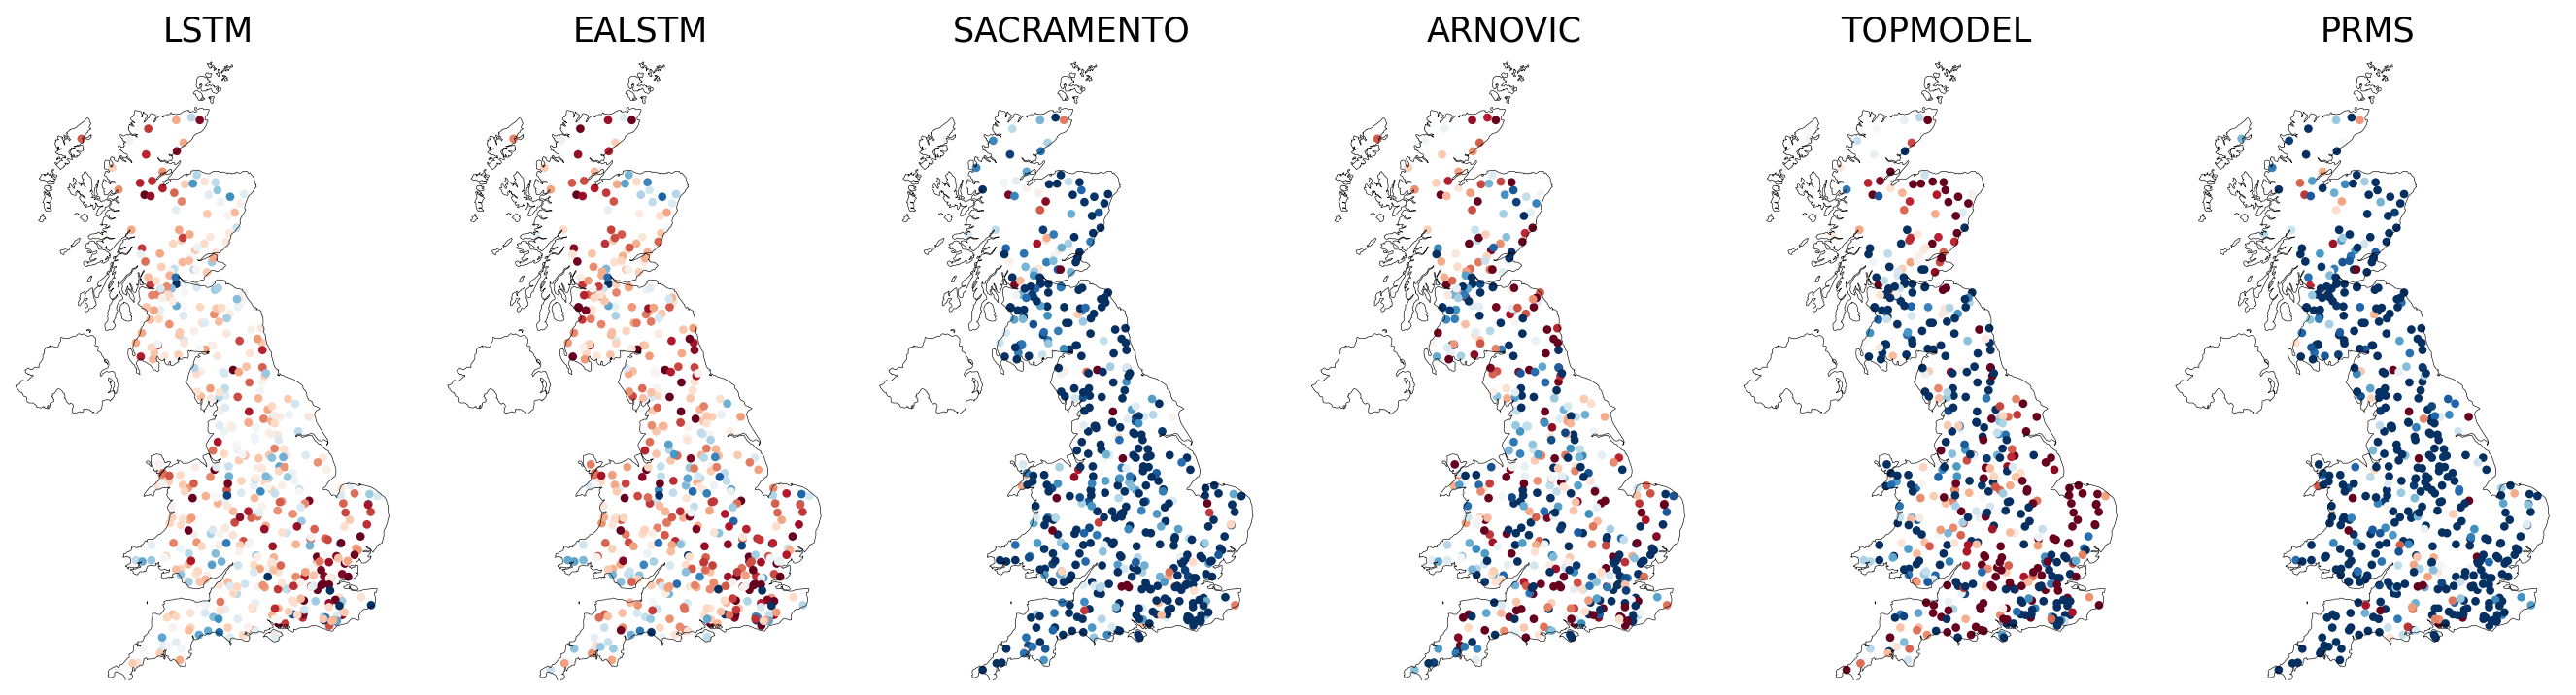

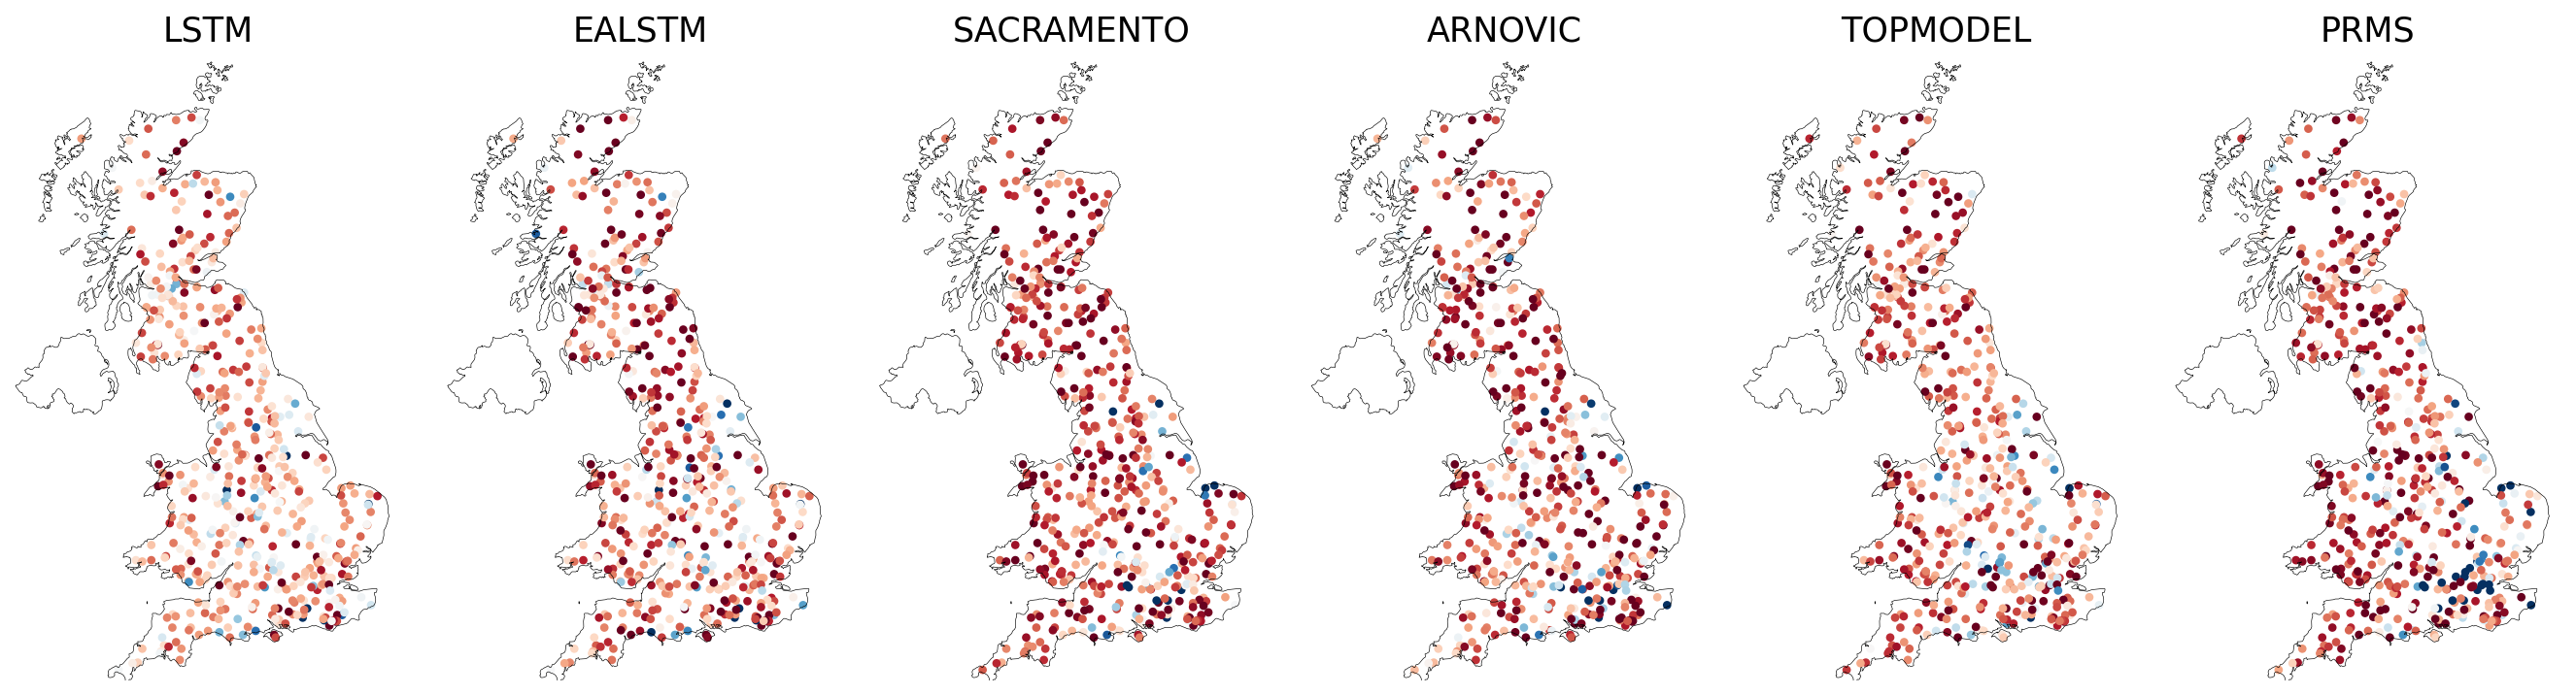

In [33]:
# fmv', 'flv', 'fhv

plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["flv"]), metric="flv", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["fms"]), metric="fms", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["fhv"]), metric="fhv", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])

In [34]:
if False:
    plot_geospatial_data_per_model(create_geospatial_data(all_errors["ARNOVIC"]), model="VIC", metrics=metrics)
    plot_geospatial_data_per_model(create_geospatial_data(all_errors["PRMS"]), model="PRMS", metrics=metrics)
    plot_geospatial_data_per_model(create_geospatial_data(all_errors["TOPMODEL"]), model="TOPMODEL", metrics=metrics)
    plot_geospatial_data_per_model(create_geospatial_data(all_errors["ARNOVIC"]), model="Sacramento", metrics=metrics)

# Seasonal


# Table of 13 Basin metrics

In [35]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [36]:
nse_only = True
process_errors = pd.read_csv(data_dir / "RUNOFF/jules_classic.csv")

# Process the CLASSIC NSE values
classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
if nse_only:
    classic = classic.drop("Bias", axis=1).rename({"NSE": "CLASSIC"}, axis=1)
else:
    classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

# Process the JULES NSE values
jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
if nse_only:
    jules = jules.drop("Bias", axis=1).rename({"NSE": "JULES"}, axis=1)
else:
    jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)

In [37]:
nse_all = all_metrics["nse"].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
nse_all = process_errors.join(nse_all).dropna()

nse_all = nse_all[["Name", "LSTM", "EALSTM"] + [c for c in nse_all.columns if c not in ["Name", "LSTM", "EALSTM"]]]

In [38]:
print(nse_all.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                        Name &  LSTM &  EALSTM &  CLASSIC &  JULES &  TOPMODEL &  ARNOVIC &  PRMS &  SACRAMENTO \\
Station ID &                             &       &         &          &        &           &          &       &             \\
\midrule
12002      &                Dee at Park  &  0.89 &    0.88 &     0.55 &   0.51 &      0.65 &     0.71 &  0.68 &        0.71 \\
15006      &           Tay at Ballathie  &  0.95 &    0.93 &     0.46 &   0.64 &      0.79 &     0.88 &  0.86 &        0.88 \\
27009      &            Ouse at Skelton  &  0.94 &    0.91 &     0.80 &   0.69 &      0.86 &     0.89 &  0.88 &        0.91 \\
27034      &      Ure at Kilgram Bridge  &  0.89 &    0.87 &     0.78 &   0.75 &      0.84 &     0.84 &  0.85 &        0.85 \\
27041      &    Derwent at Buttercrambe  &  0.93 &    0.80 &     0.65 &   0.49 &      0.77 &     0.78 &  0.82 &        0.87 \\
39001      &         Thames at Kingston  &  0.96 &    0.94 &     0.81 &  

# ∆ Performance

In [39]:
delta_nse_gdf = gpd.GeoDataFrame(lstm_delta["nse"].join(points))

In [111]:
print(delta_nse_gdf.drop("geometry", axis=1).median().to_frame().T.to_latex(float_format="%.2f"))
print(delta_nse_gdf.drop("geometry", axis=1).mean().to_frame().T.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  TOPMODEL &  ARNOVIC &  PRMS &  SACRAMENTO &  EALSTM &  persistence &  climatology\_doy &  climatology\_mon \\
\midrule
0 &      0.11 &     0.09 &  0.10 &        0.07 &    0.02 &         0.40 &             0.73 &             0.75 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  TOPMODEL &  ARNOVIC &  PRMS &  SACRAMENTO &  EALSTM &  persistence &  climatology\_doy &  climatology\_mon \\
\midrule
0 &      0.16 &     0.17 &  0.43 &        0.20 &    0.02 &         0.38 &             0.71 &             0.73 \\
\bottomrule
\end{tabular}



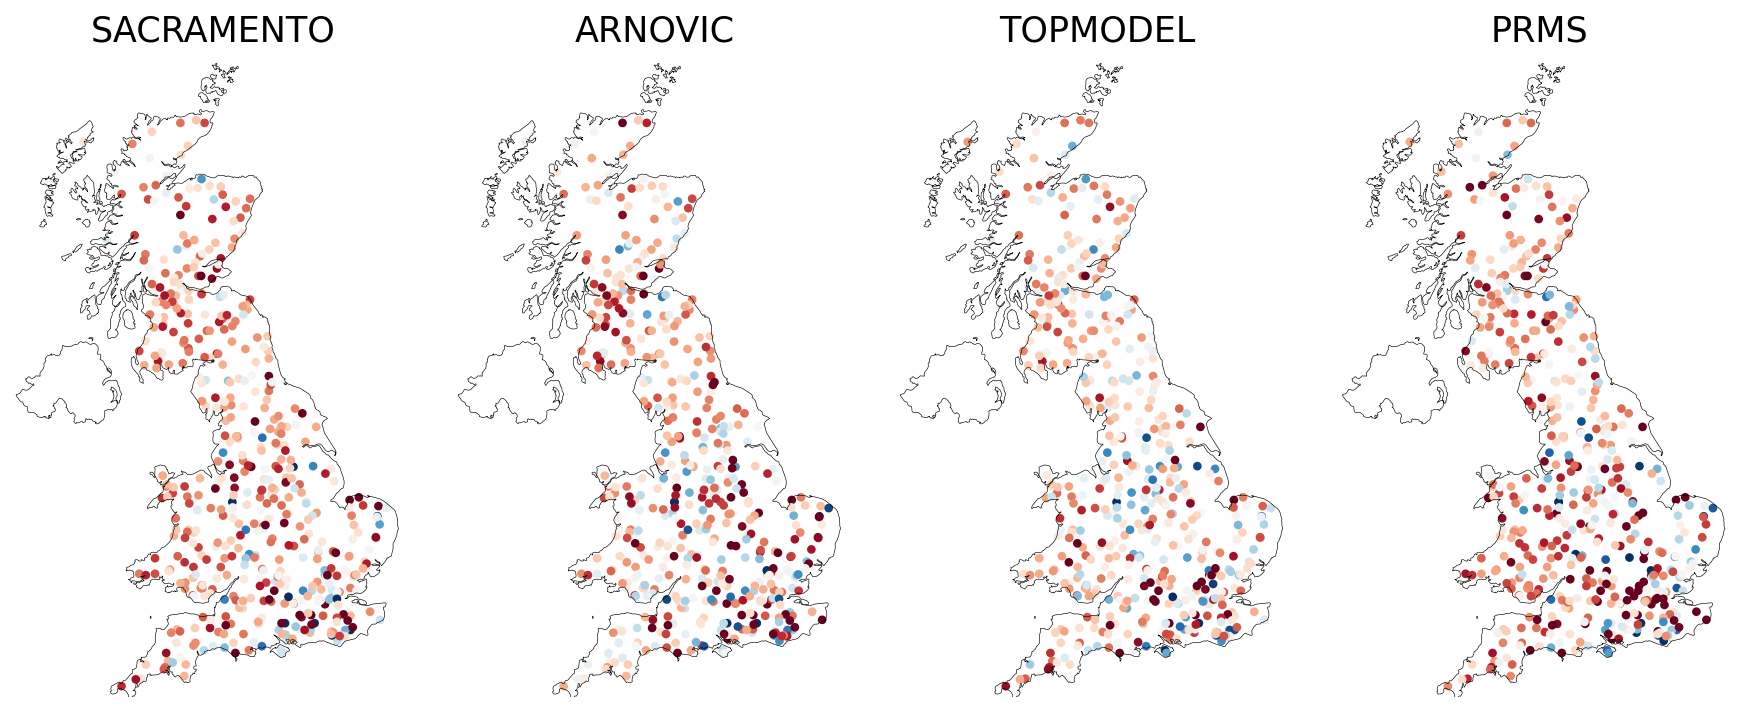

In [40]:
kwargs = {
    "nse": {"vmin": 0, "vmax": 0.2, 'cmap': 'viridis', "markersize": markersize},
    "correlation": {"vmin": -0, "vmax": 0.2, 'cmap': 'plasma', "markersize": markersize},
    "bias_error": {"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "std_error": {"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv": {"vmin": -300, "vmax": 300, 'cmap': 'RdBu', "markersize": markersize},
    "fms": {"vmin": -50, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},
    "fhv": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},
}


metric="fhv"
plot_geospatial_data_per_metric(
    create_geospatial_data(lstm_delta[metric]), 
    metric=metric, 
    models=["SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"],
    kwargs=kwargs[metric],
    legend=False,
)

# Budyko analysis
- Is the largest improvement in catchments where the water balance doesn't match?

In [41]:
from scripts.drafts.plots import plot_budyko_curve, calculate_curve_params, curve

In [42]:
import matplotlib.cm as cm
import matplotlib.colors as colors

vmin = 0
vmax = 0.5

# color_var = all_metrics["nse"]["LSTM"]
color_var = lstm_delta["nse"]["TOPMODEL"]
# norm = colors.Normalize(vmin, vmax)
# color_var = cm.viridis_r(norm(color_var))
mean_ds = ds.mean(dim="time").sel(station_id=all_metrics["nse"]["LSTM"].index)

In [43]:
median_conceptual_nse = all_metrics["nse"].loc[:, ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]].median(axis=1)

In [44]:
# sns.distplot(all_metrics["nse"].loc[:, ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]].median(axis=1), kde_kws=dict(clip=(0, 1)), hist=False)
# sns.distplot(all_metrics["nse"].loc[:, "LSTM"], kde_kws=dict(clip=(0, 1)), hist=False)

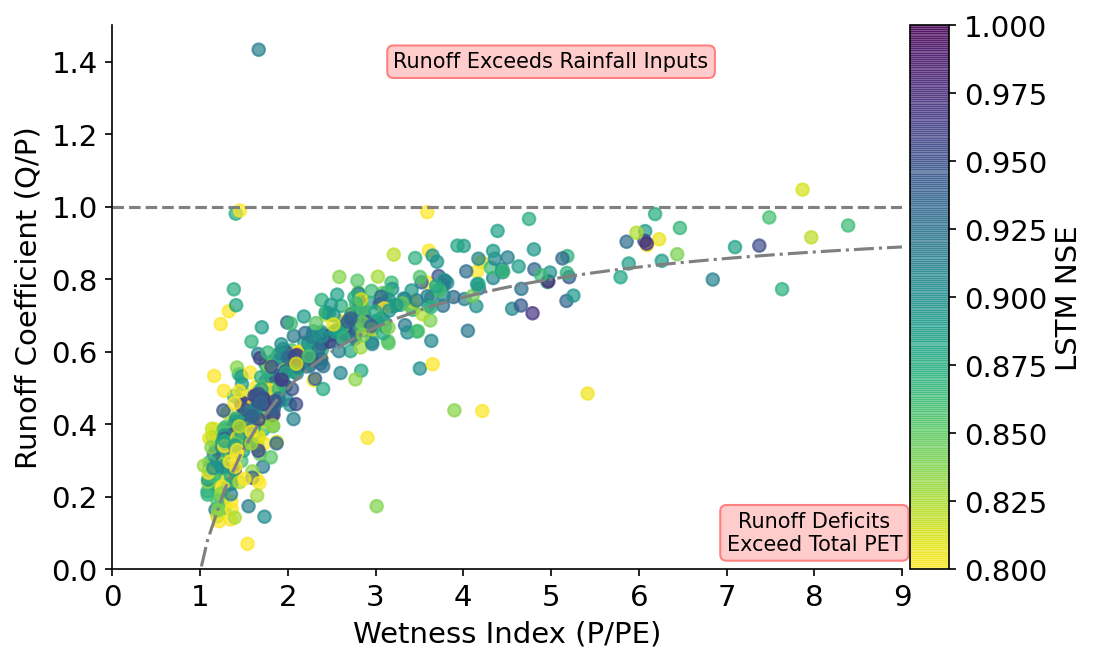

In [45]:
color_var = lstm_delta["nse"]["TOPMODEL"]
median_conceptual_nse = all_metrics["nse"].loc[:, ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]].median(axis=1)

# plot_budyko_curve(
#     ds=mean_ds,
#     color_var=median_conceptual_nse,
#     color_label="Conceptual NSE",
#     vmin=0.7,
#     vmax=1,
#     scatter_kwargs={"alpha": 0.7},
#     annotate=True
# )
plot_budyko_curve(
    ds=mean_ds,
    color_var=all_metrics["nse"]["LSTM"],
    color_label="LSTM NSE",
    vmin=0.8,
    vmax=1,
    scatter_kwargs={"alpha": 0.7, "cmap": "viridis_r"},
    annotate=True
)

In [46]:
from scripts.drafts.calculate_error_scores import FUSEPublishedScores

f = FUSEPublishedScores(fuse_dir=data_dir/"FUSE/")
published = f.read_nse_scores()
published.head()

station_id  NSE_TOPMODEL   NSE_VIC  NSE_PRMS  NSE_SACRAMENTO  \
0       10002      0.676705  0.760394  0.729084        0.755280   
1       10003      0.614465  0.794624  0.751196        0.756433   
2        1001      0.755836  0.764714  0.788691        0.806047   
3      101002      0.616119  0.696603  0.554009        0.724537   
4      101004      0.699461  0.674037  0.658303        0.760749   

   Rel_Bias_TOPMODEL  Rel_Bias_VIC  Rel_Bias_PRMS  Rel_Bias_SACRAMENTO  \
0          -5.942002      4.302407      -6.989079            -5.618925   
1          -4.106133    -12.203704     -18.871937           -22.022715   
2          -6.652462     10.373088       6.814426             3.440680   
3          20.276516      0.131108      18.781502            -8.061234   
4          17.287075     20.937721      38.282780            11.026786   

   Rel_std_TOPMODEL  Rel_std_VIC  Rel_std_PRMS  Rel_std_SACRAMENTO  \
0          2.473470   -15.795703     -3.456398           -7.949082   
1         -4.265205   -22.558733     -6.358214          -17.625877   
2        -15.259186   -16.765223     -8.968578          -11.649730   
3          1.001410    -8.049840     17.743149           -1.137864   
4        -20.829819   -12.892307    -10.831385          -15.404938   

   Correlation_TOPMODEL  Correlation_VIC  Correlation_PRMS  \
0              0.844169         0.873570          0.862684   
1              0.800834         0.913798          0.896092   
2              0.869409         0.880956          0.892675   
3              0.828486         0.838662          0.838500   
4              0.841995         0.828602          0.834819   

   Correlation_SACRAMENTO  
0                0.872114  
1                0.912475  
2                0.899145  
3                0.863804  
4                0.874284

In [47]:
concept_models = ["TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]
atol = 2e-1
for model in concept_models:
    p = published.set_index("station_id").loc[all_metrics["nse"].index][f"NSE_{'VIC' if model == 'ARNOVIC' else model}"]
    c = all_metrics["nse"][model]

    print(f"{model} within {atol}: \t{np.isclose(p, c, atol=atol).mean():.2f}")

TOPMODEL within 0.2: 	0.98
SACRAMENTO within 0.2: 	0.98
PRMS within 0.2: 	0.95
ARNOVIC within 0.2: 	0.98


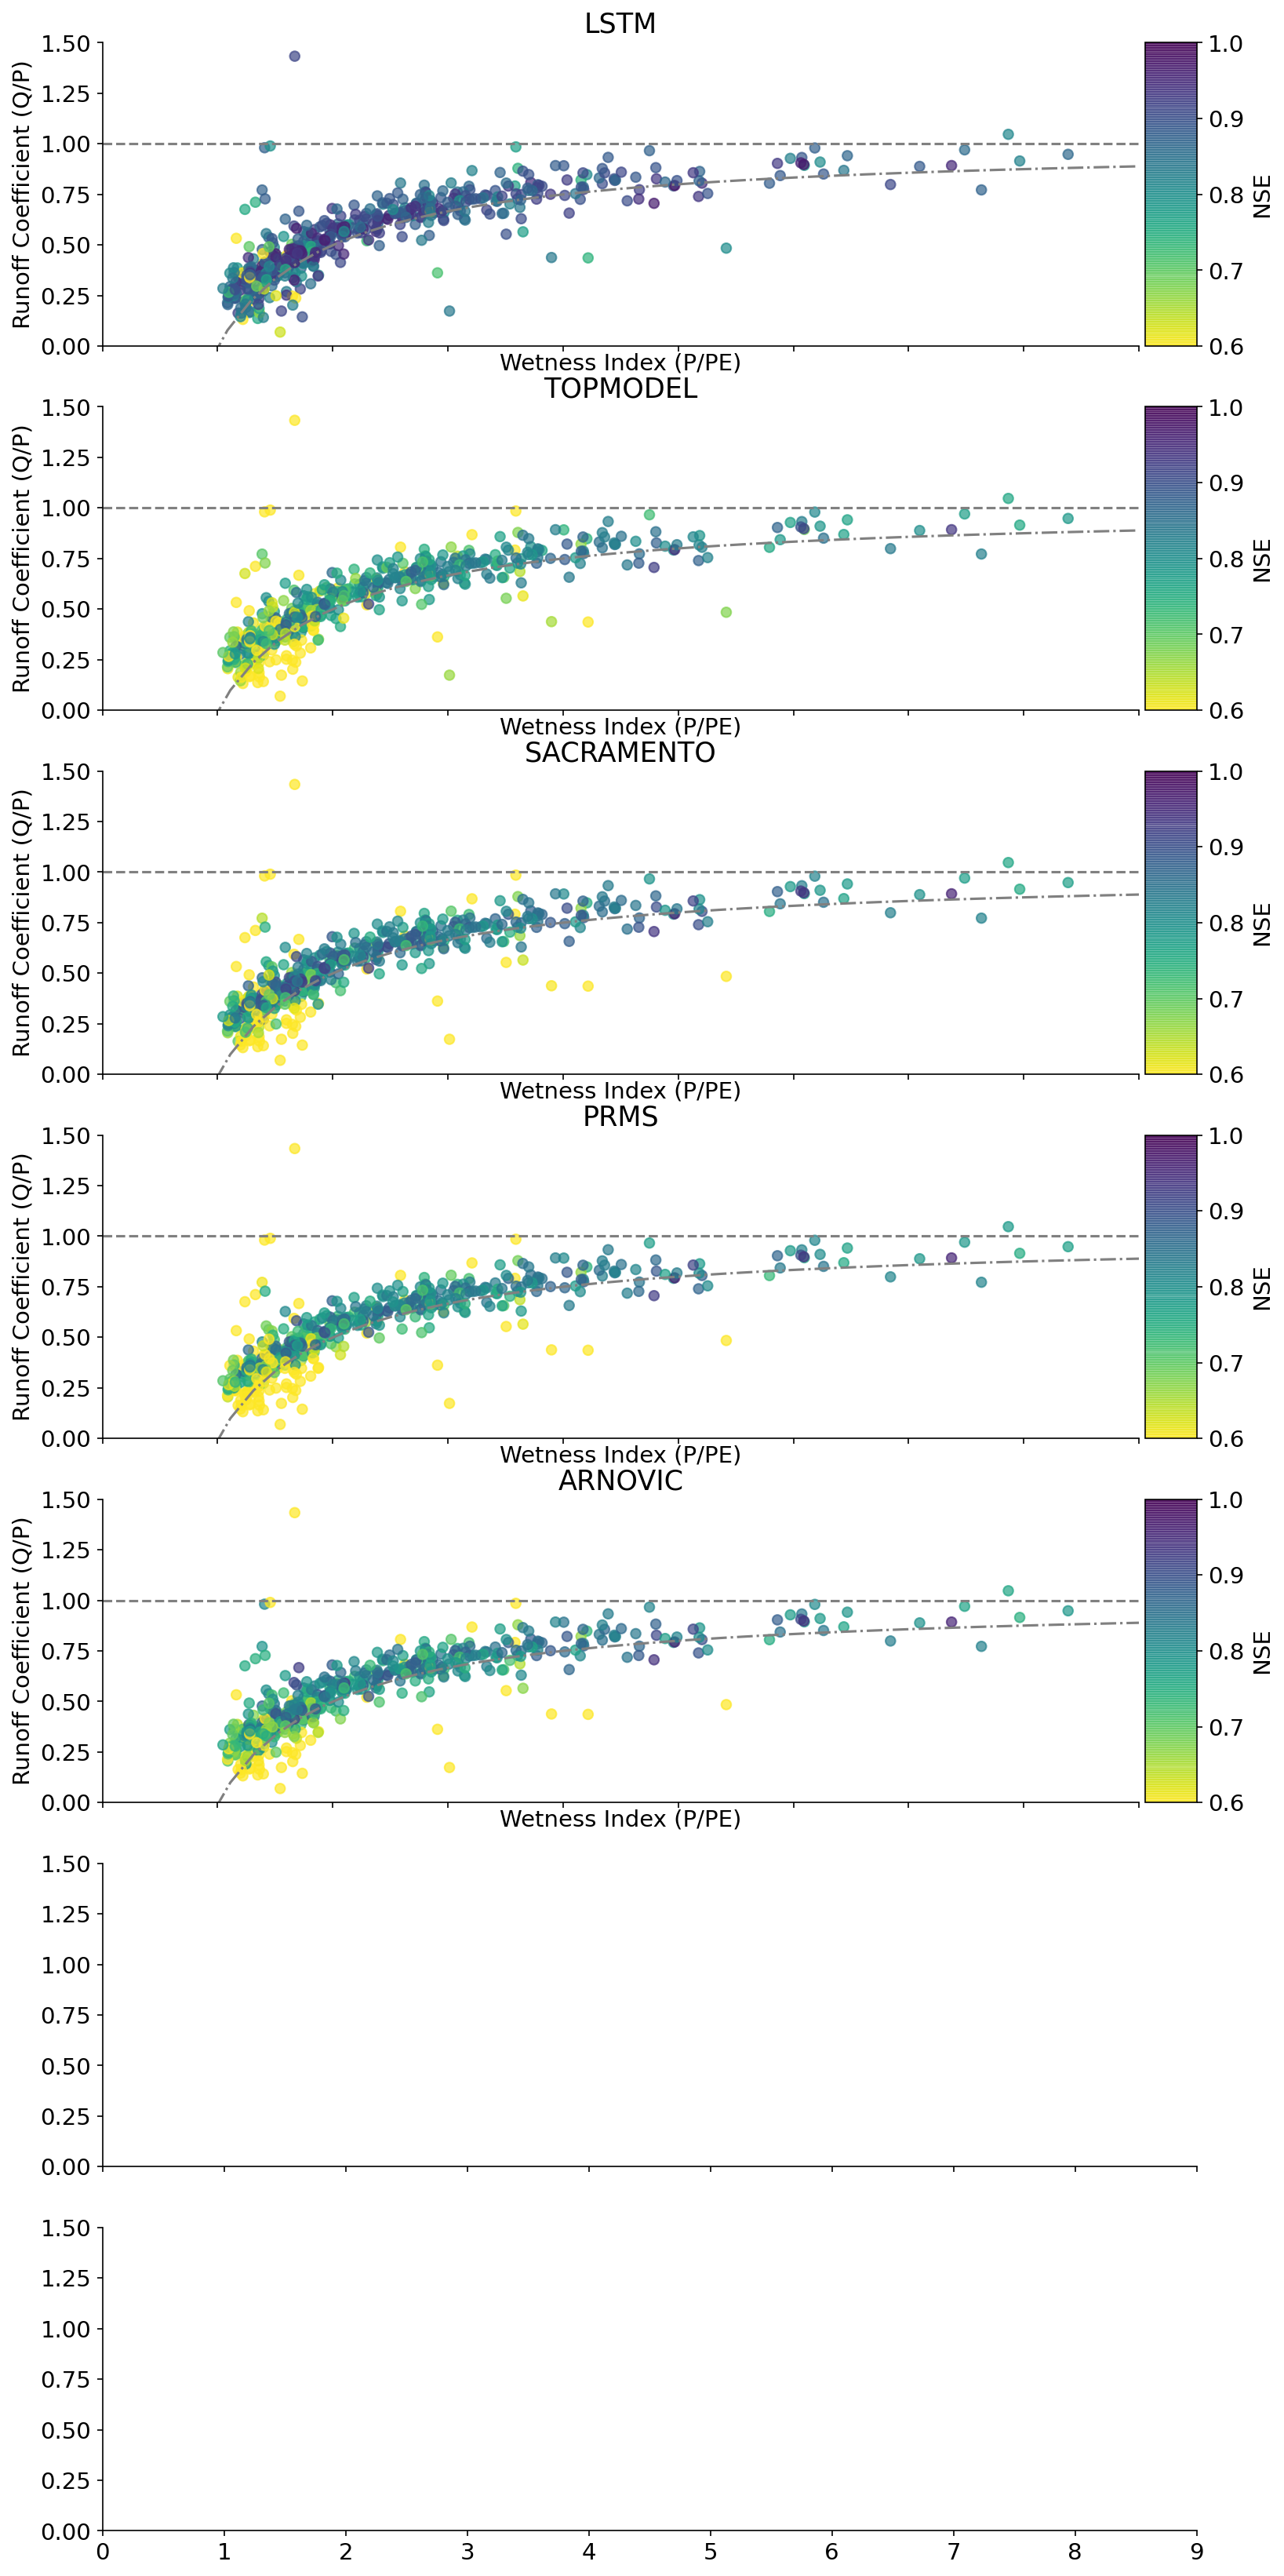

In [48]:
scale = 1

metrics = ["nse", "correlation", "bias_error", "std_error", "flv", "fms", "fhv"]
# metrics = ["nse", "correlation"]

n_subplots = len(metrics)
f, axs = plt.subplots(n_subplots, 1, sharex=True, sharey=True, figsize=(12*scale, 4*scale*n_subplots))

kwargs_lookup = {
    "nse": {"vmin": "0.8", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7},
    "correlation": {"vmin": "0.85", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7},
    "bias_error": {"vmin": "-0.25", "vmax": "0.25", "cmap": "RdBu", "alpha": 0.7},
    "std_error": {"vmin": "-0.25", "vmax": "0.25", "cmap": "RdBu", "alpha": 0.7},
    "flv": {"vmin": "-100", "vmax": "100", "cmap": "RdBu", "alpha": 0.7},
    "fms": {"vmin": "-20", "vmax": "20", "cmap": "RdBu", "alpha": 0.7},
    "fhv": {"vmin": "-20", "vmax": "20", "cmap": "RdBu", "alpha": 0.7},
}


# model = "ARNOVIC"
# color_var = published.set_index("station_id").loc[all_metrics["nse"].index, "NSE_TOPMODEL"]
# color_var = all_metrics["nse"]["TOPMODEL"]

metric = "nse"
# for ix, metric in enumerate(metrics):
for ix, model in enumerate(["LSTM", "TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]):
    kwargs_lookup = {"nse": {"vmin": "0.6", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7}}
    ax = axs[ix]
    plot_budyko_curve(
        ds=mean_ds,
        color_var=all_metrics[metric][model],  #color_var,  # all_metrics[metric][model],
        color_label=f"{metric.upper()}",
        vmin=kwargs_lookup[metric].pop("vmin"),  # ,
        vmax=kwargs_lookup[metric].pop("vmax"),  # ,
        scatter_kwargs=kwargs_lookup[metric],
        annotate=False,
        ax=ax
    )
    ax.set_title(model)


In [49]:
benchmark_models = ["persistence", "climatology_doy", "climatology_mon"]

In [71]:
all_preds.rename({""})

<xarray.Dataset>
Dimensions:          (station_id: 518, time: 7671)
Coordinates:
  * time             (time) datetime64[ns] 1988-01-01 1988-01-02 ... 2008-12-31
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
Data variables:
    TOPMODEL         (station_id, time) float64 ...
    ARNOVIC          (station_id, time) float64 ...
    PRMS             (station_id, time) float64 ...
    SACRAMENTO       (station_id, time) float64 ...
    EALSTM           (station_id, time) float64 ...
    obs              (station_id, time) float64 ...
    LSTM             (station_id, time) float64 ...
    persistence      (time, station_id) float64 ...
    climatology_doy  (time, station_id) float64 ...
    climatology_mon  (time, station_id) float64 ...

In [74]:
from scripts.drafts.plots import calculate_curve_params, curve

# get_points_below_curve ()
x, y = calculate_curve_params(ds=ds.mean(dim="time"))

ref_y = curve(x)
# below line means that y_obs < y_ref
(y < ref_y)

stations_where_remaining_h2o_lt_pet = (y < ref_y).rename("unphysical")
stations_where_remaining_h2o_lt_pet

<xarray.DataArray 'unphysical' (station_id: 671)>
array([False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False,  True, False, False, False,  True,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False,  True, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True, False,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True,  True, False,  True,  True, False, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  T

In [75]:
nse_physical = all_metrics["nse"].join(stations_where_remaining_h2o_lt_pet.to_dataframe()).copy()
nse_physical

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM      LSTM  \
station_id                                                                 
1001        0.754303  0.766521  0.786218    0.805396  0.861309  0.875410   
2001        0.655162  0.685077  0.686722    0.699972  0.774883  0.795517   
2002        0.691850  0.681148  0.683937    0.697952  0.778065  0.796522   
3003        0.806642  0.799981  0.793153    0.805893  0.824149  0.879771   
4001        0.724438  0.818019  0.777022    0.792738  0.858983  0.873894   
...              ...       ...       ...         ...       ...       ...   
97002       0.703853  0.712480  0.699126    0.718971  0.842318  0.870236   
101002      0.640498  0.701483  0.607752    0.721176  0.729133  0.757151   
101005      0.638764  0.665835  0.443187    0.697576  0.810807  0.827427   
102001      0.716570  0.727396  0.715925    0.712600  0.789536  0.809664   
106001      0.816301  0.849329  0.840715    0.838882  0.853072  0.881478   

            persistence  climatology_doy  climatology_mon  unphysical  
station_id                                                             
1001           0.579773         0.292575         0.254580       False  
2001           0.356727         0.198373         0.175451       False  
2002           0.446497         0.203463         0.163719       False  
3003           0.154109         0.135698         0.113008        True  
4001           0.792629         0.363090         0.342141       False  
...                 ...              ...              ...         ...  
97002          0.412503         0.207629         0.181226       False  
101002         0.293551         0.147030         0.130564       False  
101005         0.193565         0.118744         0.100562        True  
102001         0.212084         0.223625         0.182190       False  
106001         0.686543         0.325149         0.264456       False  

[518 rows x 10 columns]

In [76]:
nse_physical.loc[~nse_physical["unphysical"], model]

station_id
1001      0.786218
2001      0.686722
2002      0.683937
4001      0.777022
5003      0.758339
            ...   
96004     0.760665
97002     0.699126
101002    0.607752
102001    0.715925
106001    0.840715
Name: PRMS, Length: 403, dtype: float64

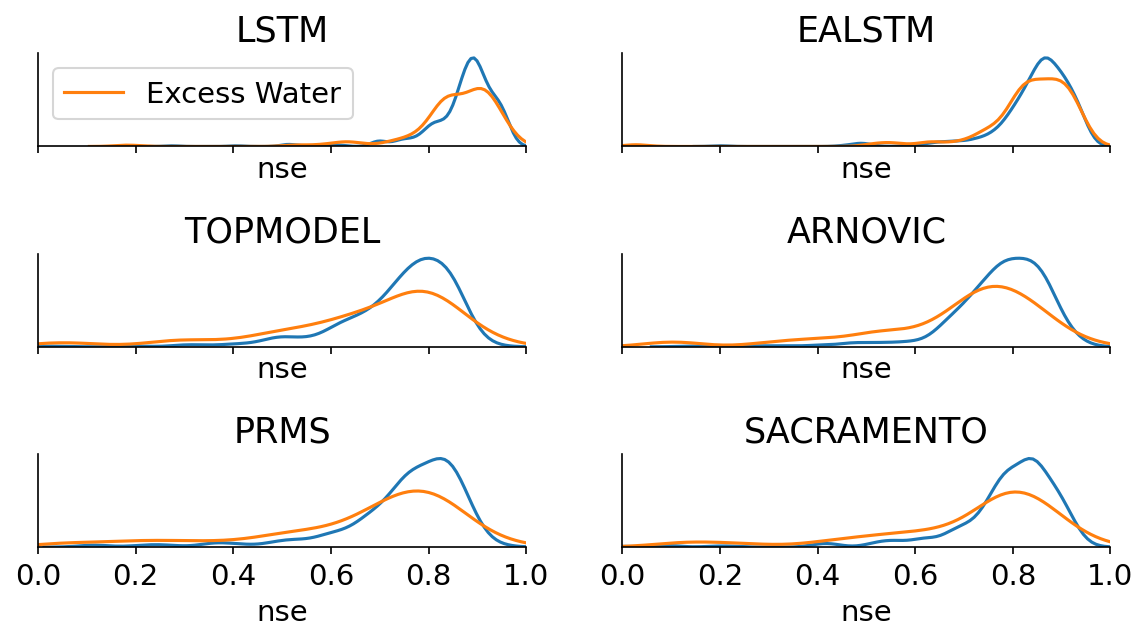

In [77]:
models = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO",]

scale = 1
subplot_size = (3, 2)
f, axs = plt.subplots(subplot_size[0], subplot_size[1], sharex=True, figsize=(4*scale* subplot_size[1], 1.5*scale*subplot_size[0]))
clip = (0, 1)
for ix, model in enumerate(models):
    ax = axs[np.unravel_index(ix, subplot_size)]
    sns.distplot(nse_physical.loc[~nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=clip), hist=False)
    sns.distplot(nse_physical.loc[nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=clip), hist=False, label="Excess Water")
    ax.set_yticklabels([""])
    ax.set_yticks([])
    ax.set_xlim(clip)
    ax.set_title(model)
    sns.despine()
    if ix != 0:
        ax.get_legend().remove()


plt.tight_layout()

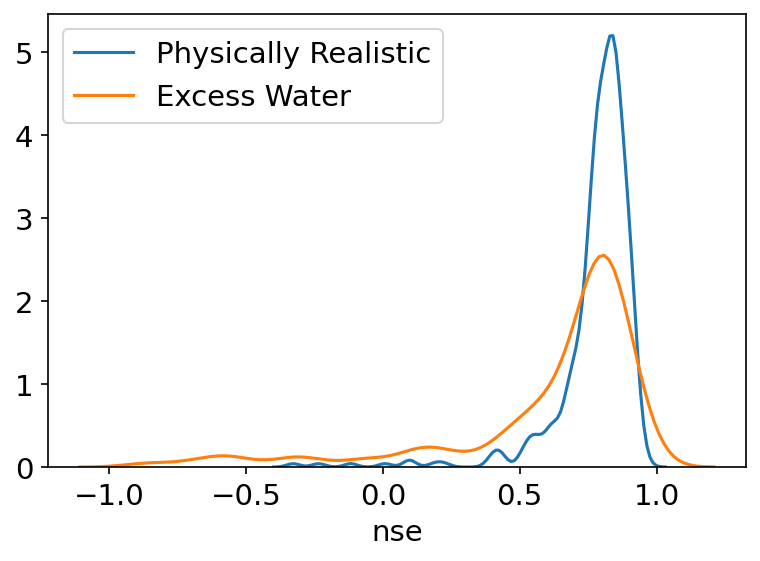

In [78]:
f, ax = plt.subplots()
sns.distplot(nse_physical.loc[~nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=(-1, 1)), hist=False, label="Physically Realistic")
sns.distplot(nse_physical.loc[nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=(-1, 1)), hist=False, label="Excess Water")
ax.legend()

## What impact on ∆NSE?

In [81]:
unphysical = lstm_delta["nse"].loc[stations_where_remaining_h2o_lt_pet.sel(station_id=all_preds.station_id).values, [c for c in lstm_delta["nse"] if "bool" not in c]]  # .rename("unphysical")
physical = lstm_delta["nse"].loc[~stations_where_remaining_h2o_lt_pet.sel(station_id=all_preds.station_id).values, [c for c in lstm_delta["nse"] if "bool" not in c]]  # .rename("physical")

print(len(unphysical))
print(len(physical))

115
403


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

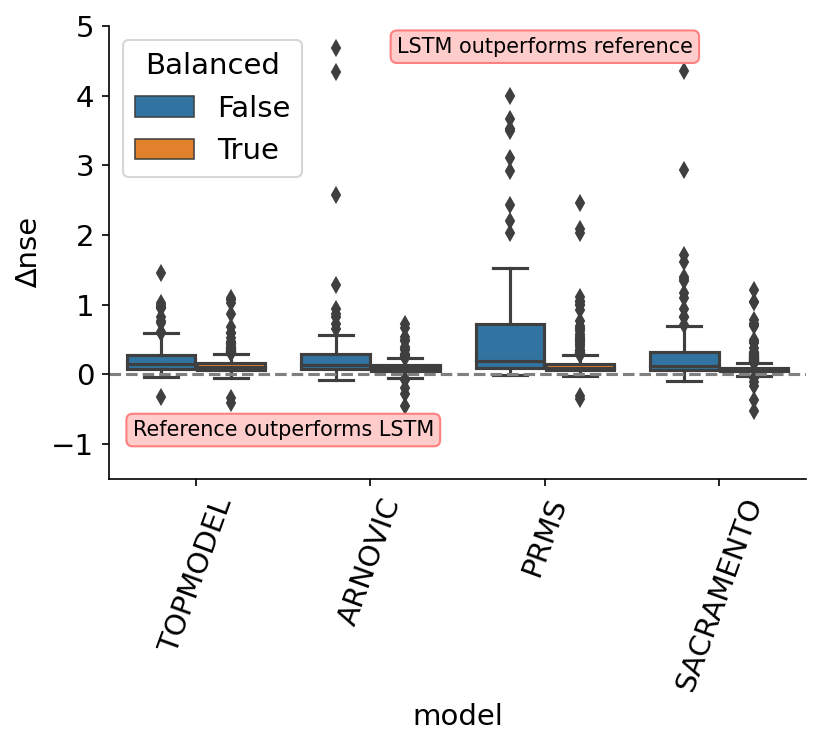

In [84]:
def _add_annotations(ax):
    ax.text(
        0.5,
        -0.8,
        "Reference outperforms LSTM",
        size=10,
        rotation=0,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round", ec=(1.0, 0.5, 0.5), fc=(1.0, 0.8, 0.8),),
    )

    ax.text(
        2,
        4.7,
        "LSTM outperforms reference",
        size=10,
        rotation=0,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round", ec=(1.0, 0.5, 0.5), fc=(1.0, 0.8, 0.8),),
    )

# physical.shape
delta_df = lstm_delta["nse"].drop([c for c in lstm_delta["nse"] if "bool" in c] + benchmark_models + ["EALSTM"], axis=1)
delta_df["balanced"] = ~stations_where_remaining_h2o_lt_pet.sel(station_id=all_preds.station_id)
delta_df = delta_df.reset_index().melt(id_vars=["station_id", "balanced"]).rename({"variable": "model", "value": "∆nse"}, axis=1)

f, ax = plt.subplots()
sns.boxplot(data=delta_df, hue="balanced", x="model", y="∆nse")
ax.set_ylim(-1.5, 5)
ax.axhline(0, ls="--", color="grey")
ax.legend(loc="upper left", title="Balanced")
sns.despine()
_add_annotations(ax)
plt.xticks(rotation=70)

In [85]:
# y = all_metrics["nse"]["SACRAMENTO"]
# x = static["baseflow_index"].sel(station_id=y.index)

# plt.scatter(x, y)

# seasonal_metrics

In [86]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs


seasonal_deltas = defaultdict(dict)
for month in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_deltas[month]["LSTM"], seasonal_deltas[month]["EALSTM"] = calculate_all_delta_dfs(seasonal_metrics[month])

In [87]:
from typing import DefaultDict, Tuple


def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3), legend_all: bool = False):
    fig, axs = plt.subplots(1, 4, figsize=(6*4, 4*1))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (4))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
            ax.set_title(model)
            if not legend_all:
                if ix != 0:
                    ax.get_legend().remove()

            sns.despine()
            ax.set_xlim(clip)

    plt.tight_layout()


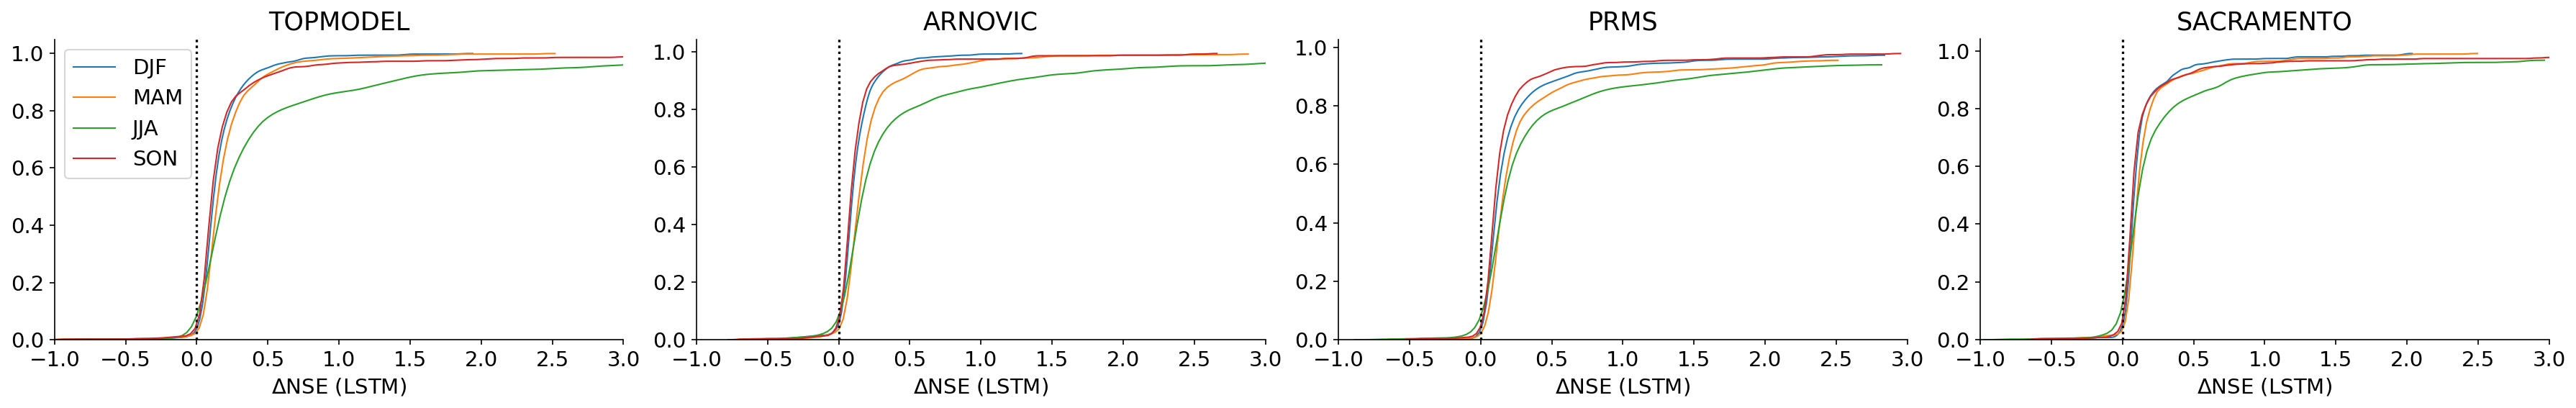

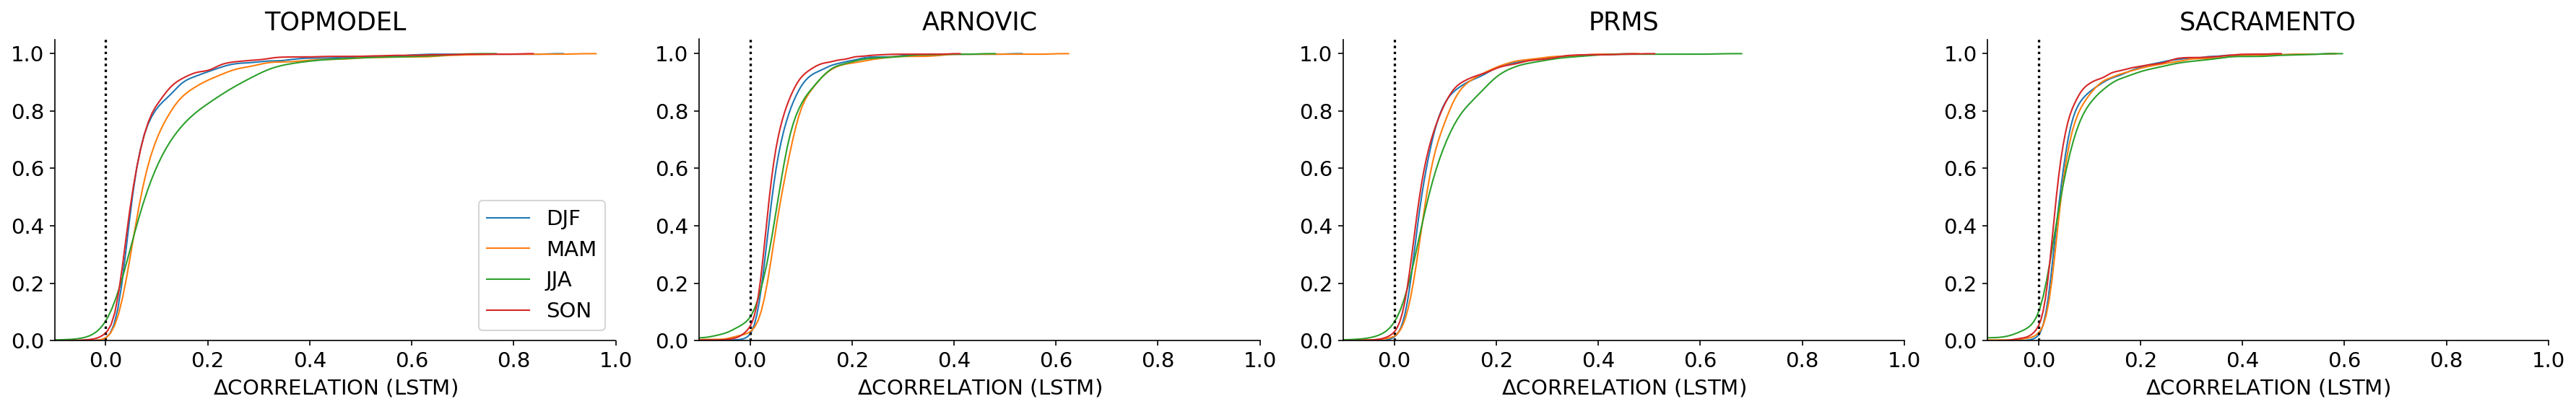

In [88]:
plot_seasonal_ecdfs(seasonal_deltas, metric="nse")
plot_seasonal_ecdfs(seasonal_deltas, metric="correlation", clip=(-0.1, 1))
# plot_seasonal_ecdfs(seasonal_deltas, metric="bias_error", clip=(-1, 1))
# plot_seasonal_ecdfs(seasonal_deltas, metric="std_error", clip=(-1, 1))

In [89]:
# plot_seasonal_ecdfs(seasonal_deltas, metric="bias_error")
# plot_seasonal_ecdfs(seasonal_deltas, metric="std_error")
# plot_seasonal_ecdfs(seasonal_deltas, metric="correlation")

In [90]:
# plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["flv"]), metric="flv", models=["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])

In [91]:
# plot as box and whisker

In [92]:
# df = seasonal_deltas[seas][reference_model][metric]
# df

In [93]:
seas = "DJF"


def create_long_form_seasonal_df(seasonal_deltas: DefaultDict[str, Dict[str, pd.DataFrame]], reference_model: str = "LSTM") -> pd.DataFrame:
#     seasonal_deltas
    reference_model = "LSTM"
    seasons = [k for k in seasonal_deltas.keys()]
    metrics = seasonal_deltas[seasons[0]][reference_model].keys()

    all_dfs = defaultdict(list)
    for seas in seasons:
        ix = 0
        for metric in metrics:
            df = seasonal_deltas[seas][reference_model][metric]
            if "season" in df.columns:
                df = df.drop("season", axis=1)
            df = df.reset_index().melt(id_vars="station_id").rename({"variable": "model", "value": metric}, axis=1)
            df["season"] = seas
            df = df.set_index(["station_id", "season"])



            if ix != 0:
                df = df.drop(["model"], axis=1)

            all_dfs[seas].append(df)
            ix += 1

    df = pd.concat([pd.concat(all_dfs[seas], axis=1) for seas in all_dfs.keys()])
    df = df.reset_index()
    return df

In [96]:
seasonal_df = create_long_form_seasonal_df(seasonal_deltas)

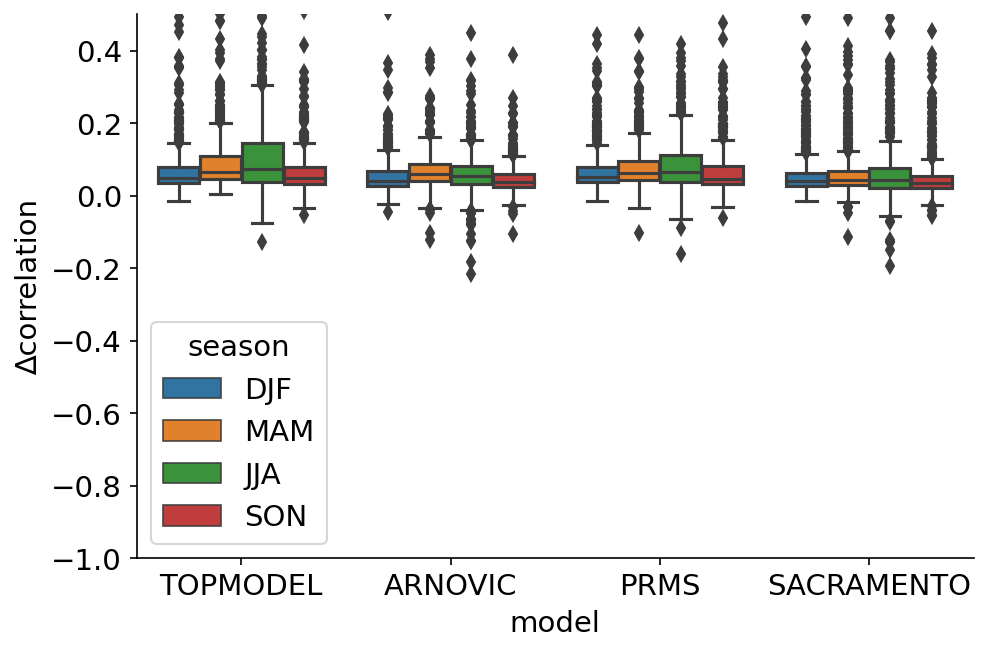

In [97]:
metric = "correlation"
models = ["TOPMODEL","ARNOVIC", "PRMS", "SACRAMENTO"]

df = seasonal_df.loc[np.isin(seasonal_df["model"], models)]
f, ax = plt.subplots(figsize=FIGSIZE)
sns.boxplot(data=df, hue="season", x="model", y=metric)
# ax.boxplot(df[metric], vert=False, labels=df["model"])

ax.set_ylabel(f"∆{metric}")
ax.set_ylim(-1, 0.5)
sns.despine()

# Do static features correlate with performance?

In [ ]:
static_df = static.sel(station_id=all_preds.station_id).to_dataframe()
# get only the non-nan numeric attributes
static_df = static_df.loc[:, static_df.dtypes == "float64"].dropna(axis=1)

In [ ]:
from scipy.stats import spearmanr, kendalltau


def calculate_correlation_with_static_features(metric_values: pd.Series, static_df: pd.DataFrame, method: str = "spearman") -> pd.DataFrame:
    func_lookup = {
        "kendall": kendalltau,
        "spearman": spearmanr,
    }
    out = defaultdict(list)
    
    static_df = static_df.loc[metric_values.index]
    assert all(static_df.index == metric_values.index)
    
    for feature in static_df.columns:
        result = func_lookup[method](metric_values, static_df[feature])
        out["correlation"].append(result.correlation)
        out["pvalue"].append(result.pvalue)
        out["variable"].append(feature)

    rank_correlations = pd.DataFrame(out)
    return rank_correlations

metric = all_errors["LSTM"]["nse"]
rank_correlations = calculate_correlation_with_static_features(metric, static_df, method="kendall")

# subset based on P Value < 0.01
significant = rank_correlations.loc[(rank_correlations.pvalue < 0.01) & (abs(rank_correlations.correlation) > 0.1)]

In [ ]:
from typing import Optional, List, Dict, Tuple, DefaultDict
import pandas as pd
import numpy as np


def rank_correlation_static_metric(metric_df: pd.DataFrame, static: Optional[xr.Dataset] = None, method: str = "spearman"):
    if static is None:
        static = xr.open_dataset("/cats/datstore/data/RUNOFF/")
    
    static_df = static.to_dataframe()
    stations = metric_df.index
    # numerical non nan rows of matching stations
    static_df = static_df.loc[stations, (static_df.dtypes == "float64")]
    static_df = static_df.loc[:, ~(static_df.isnull().mean(axis=0) > 0)]
    
    # calculate rank correlation between all static features and performance metric
    all_spearmans: Dict[str, pd.DataFrame] = {}
    for model in metric_df.columns:
        # run the correlation
        spear_df = calculate_correlation_with_static_features(metric_df[model], static_df, method=method)
        spear_df["model"] = model
        all_spearmans[model] = spear_df
        
    return all_spearmans

In [ ]:
def subset_significant_features(corrs: pd.DataFrame, pvalue: float = 0.01, coefficient_threshold: Optional[float] = None):
    corrs = corrs.loc[(corrs.pvalue < pvalue)]
    if coefficient_threshold is not None:
        corrs = corrs.loc[(abs(corrs.correlation) > coefficient_threshold)]
    
    return corrs.reindex(corrs.correlation.abs().sort_values(ascending=False).index)

## Correlation with raw metrics

In [ ]:
from src.preprocess._camels_static_metadata import groupings
hydro_static = static_df[[c for c in groupings["hydrologic_attributes"] if c!= "gauge_id"]]

In [ ]:
groupings["hydrologic_attributes"]

In [ ]:
# corrs.loc[(corrs.pvalue < 0.01) & (abs(corrs.correlation) > 0.2)].reindex(significant.correlation.abs().sort_values(ascending=False).index)
metric = "nse"
important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]
correlations = rank_correlation_static_metric(all_metrics[metric], static[important_features], method="spearman")
for model in ["LSTM", "EALSTM"]:
    corrs = correlations[model]
    display(subset_significant_features(corrs, pvalue=0.01, coefficient_threshold=0.2).head(10))

In [ ]:
metric = "nse"
correlations = rank_correlation_static_metric(all_metrics[metric], static[important_features], method="spearman")
corrs = correlations["LSTM"]
d = (subset_significant_features(corrs, pvalue=0.01)).sort_values("correlation")
sns.barplot(data=d, x="variable", y="correlation", color="C0")
sns.despine()
plt.xticks(rotation=70)

In [ ]:
metric = "correlation"

correlations = rank_correlation_static_metric(all_metrics[metric], static[important_features], method="spearman")
all_df = []
for key in correlations.keys():
    all_df.append(correlations[key])
    
corr_df = pd.concat(all_df)

corr_df.to_csv(data_dir / f"RUNOFF/{metric}_corr_df.csv")

In [ ]:
len(important_features)

## Correlation Matrix

In [ ]:
# from sklearn.preprocessing import StandardScaler

# dd = all_metrics["nse"].join(static_df["baseflow_index"])

# scaler = StandardScaler()
# # sns.distplot(dd["LSTM"])
# sns.distplot(scaler.fit_transform(dd["LSTM"].values.reshape(-1, 1)))
# sns.despine()

In [ ]:
# plt.scatter(dd["LSTM"], dd["baseflow_index"])

## Correlation with DELTA (∆NSE)

In [ ]:
metric = "nse"
delta_correlations = rank_correlation_static_metric(lstm_delta[metric], static)
for model in ["SACRAMENTO", "ARNOVIC", "PRMS", "TOPMODEL"]:
    corrs = delta_correlations[model]
    display(subset_significant_features(corrs, pvalue=0.01, coefficient_threshold=None).head())

## Join ALL conceptual models into one big spearmans rank ... (DUBIOUS)

In [ ]:
metric = "abs_pct_bias"
stacked = lstm_delta[metric].loc[:, ["TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]].reset_index().melt(id_vars="station_id").rename({"variable": "model", "value": metric}, axis=1)
stacked = stacked.set_index("station_id").join(static_df)

out = defaultdict(list)
for feature in stacked.drop(["model", metric], axis=1).columns:
    res = spearmanr(stacked[metric], stacked[feature])
    out["correlation"].append(res.correlation)
    out["pvalue"].append(res.pvalue)
    out["variable"].append(feature)

result = pd.DataFrame(out)
display(subset_significant_features(result, pvalue=0.01, coefficient_threshold=None))

In [ ]:
# spearmanr(static_df["baseflow_index"], static_df["baseflow_index_ceh"])

In [ ]:
feature = "baseflow_index"
dd = all_metrics["nse"].join(static_df["baseflow_index"])
# region_list

# Marginalia

In [ ]:
assert False, "Don't run these cells"

## Cluster the static features

In [ ]:
sdf = static.to_dataframe()
sdf = sdf.loc[:, (sdf.dtypes == "float64")]
sdf = sdf.drop("reservoir_drain", axis=1)
sdf = sdf.drop([c for c in sdf.columns if "uncert" in c] + [c for c in sdf.columns if "missing" in c], axis=1)

from sklearn.impute import SimpleImputer
X = SimpleImputer(strategy='mean').fit_transform(sdf)
X = pd.DataFrame(X, index=sdf.index, columns=sdf.columns)

In [ ]:
# corr = pd.DataFrame(corr, index=sdf.columns, columns=sdf.columns)
# np.isfinite(corr)

# corr.loc[corr.index.difference(corr.dropna(how='all').index)]

In [ ]:
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

scale = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12*scale, 8*scale))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(sdf.columns), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# ?importances

In [ ]:
important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]
# important_features = [
#     # Hydrologic Attributes
#     "runoff_ratio",
#     "slope_fdc",
#     "baseflow_index",
#     "Q5",
#     #  climatic indices
#     "aridity",
#     "frac_snow",
# ]

categorical_features = [
    "dom_land_cover",
    "high_prec_timing",
    "low_prec_timing",
]
numerical_features = [
    "reservoir_cap"
]

def create_X(Ys: pd.Series, categorical: bool = False, integers: bool = False) -> pd.DataFrame:
    features = important_features
    if categorical:
        features += categorical_features 
    if integers:
        features += numerical_features 
    X = static.to_dataframe().loc[Ys.index, features]
    return X

In [ ]:
def create_XY(model: str, metric: str = "nse", categorical: bool = False, integers: bool = True) -> Tuple[pd.DataFrame, pd.Series]:
    # get train pairs
    Ys = all_metrics["nse"]["LSTM"].dropna()
    X = create_X(Ys)
    
    assert len(X) == len(Ys)
    return X, Ys

categorical = False
model = "LSTM"
X, Ys = create_XY("LSTM", metric="nse", categorical=categorical)
display(Ys.head())

In [ ]:
# Processing and fitting pipeline
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('normalizer', ),
#     ('dimensional_reduction', PCA(n_components=4))
])

if categorical:
    preprocessing = ColumnTransformer(
        [
            ('cat', categorical_pipe, categorical_features),
            ('num', numerical_pipe, numerical_features)
        ]
    )
else:
    preprocessing = ColumnTransformer(
        [
            ("num", numerical_pipe, important_features)
        ]
    )

rf = Pipeline([
    ('preprocess', preprocessing),
    ('Regressor', RandomForestRegressor(random_state=1, max_features=0.1, oob_score=True, criterion="mse", n_estimators=10))
])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Ys, test_size=0.1, random_state=1)
rf.fit(X_train, y_train);

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

In [ ]:
imp_test = importances(rf, X_test, y_test)
imp = importances(rf, X_train, y_train)

# f, ax = plt.subplots()
# plot_importances(imp, ax=ax)
# f, ax = plt.subplots()
# plot_importances(imp_test, ax=ax)

In [ ]:
from rfpimp import plot_corr_heatmap


# scale = 1.5
# viz = plot_corr_heatmap(X, figsize=(7*scale,5*scale))

## cluster static features

In [ ]:
# corr
# X.columns[dendro["leaves"]]
# dendro

In [ ]:
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(X.columns), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [ ]:
result = permutation_importance(rf, X, Ys, n_repeats=100,
                                random_state=42, n_jobs=4)

n_features = -1
sorted_idx = result.importances_mean.argsort()[:n_features]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
# ?permutation_importance

# Create artificial time-series of HIGH, MED, LOW discharges

In [ ]:
# ds["discharge_spec"]
test_period = ("01-01-1998", "31-12-2008")
test_days = pd.date_range(test_period[0], test_period[1], freq="D")
all_days = pd.date_range("01-01-1970", test_period[1], freq="D")
train_days = [d for d in all_days if d not in test_days]
train_discharge = ds["discharge_spec"].sel(time=slice(train_days[0], train_days[-1]))

In [ ]:
q30 = train_discharge.quantile(q=0.3, dim="time").sel(station_id=all_preds.station_id)
q80 = train_discharge.quantile(q=0.8, dim="time").sel(station_id=all_preds.station_id)
q98 = train_discharge.quantile(q=0.98, dim="time").sel(station_id=all_preds.station_id)

In [ ]:
if False:
    condition = all_preds["obs"] < q30

    # only keep values matching condition
    # calculate errors only on those discharge that match condition
    if "condition_errors" not in [k for k in globals().keys()]:
        condition_errors = calculate_all_data_errors(all_preds.where(condition), decompose_kge=True)
        
    condition_metrics = get_metric_dataframes_from_output_dict(condition_errors)

In [ ]:
if False:
    f, axs = plt.subplots(2, 2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]*2))

    clipping_lookup = {
        "nse": (-100, 1),
        "kge": (0, 1),
        "correlation": (0, 1),
        "bias_ratio": (0, 1.5),
        "variability_ratio": (0, 1.5),
        "bias_error": (-1, 1),
        "std_error": (-1, 1),
    }

    for ix, metric in enumerate(["nse", "correlation", "bias_error", "std_error"]):
        ax = axs[np.unravel_index(ix, (2,2))]
        metric_data = condition_metrics[metric].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
        plot_cdf(metric_data, metric=metric, title="", ax=ax, clip=clipping_lookup[metric], median=True, summary_line=False, legend=True);
    #     ax.legend().set_visible(False)

# Portions of the Hydrograph

In [ ]:
test_period = ("01-01-1998", "31-12-2008")
test_days = pd.date_range(test_period[0], test_period[1], freq="D")

In [ ]:
all_preds 

In [ ]:
# def plot_fdc

def _get_fdc(da: xr.DataArray) -> np.ndarray:
    return da.sortby(da, ascending=False).values


# da = ds["discharge_spec"].isel(station_id=100).sel(time=test_days).dropna(dim="time")
obs = all_preds["obs"].isel(station_id=100)
sim = all_preds["LSTM"].isel(station_id=100)

obs_fdc = _get_fdc(obs)
sim_fdc = _get_fdc(sim)
plt.plot(np.arange(len(obs_fdc)) / len(obs_fdc), obs_fdc, label="Obs")
plt.plot(np.arange(len(sim_fdc)) / len(sim_fdc), sim_fdc, label="Sim")

ax = plt.gca()
ax.set_ylabel("Discharge [mm/day]")
ax.set_xlabel("Flow Exceedence Probability")
ax.set_xlim(-0.01, 1.01)

plt.yscale("log")
plt.legend()

# low flows
ax.axvline(0.7, ls="--", color="grey")
# high flows
ax.axvline(0.02, ls="--", color="grey")
# midflows
ax.axvline(0.2, ls="--", color="grey")
ax.axvline(0.8, ls="--", color="grey")

In [ ]:
sim_fdc[sim_fdc <= 0] = 1e-6
obs_fdc[obs_fdc == 0] = 1e-6


# calculate fms part by part
lower = 0.2
upper = 0.7 

qsm_lower = np.log(sim_fdc[np.round(lower * len(sim_fdc)).astype(int)])
qsm_upper = np.log(sim_fdc[np.round(upper * len(sim_fdc)).astype(int)])
qom_lower = np.log(obs_fdc[np.round(lower * len(obs_fdc)).astype(int)])
qom_upper = np.log(obs_fdc[np.round(upper * len(obs_fdc)).astype(int)])

In [ ]:
fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)
fms * 100

In [ ]:
print((qsm_lower - qsm_upper))
print((qom_lower - qom_upper))
print(((qsm_lower - qsm_upper) - (qom_lower - qom_upper)))

In [ ]:
all_metrics.keys()

In [ ]:
# all_metrics["mam30_ape"]
f, ax = plt.subplots(figsize=FIGSIZE)
metrics = all_metrics["mam30_ape"].drop([c for c in  all_metrics["nse"].columns if "climatology" in c or "persistence" in c], axis=1)
plot_cdf(metrics, metric="mam30_ape", title="", ax=ax, clip=(0, 200), median=True);